# FORK 1
## cross_electrode_phase_locking_fork1.ipynb

## Sub-delta, delta, low theta, high theta, alpha-beta


In [13]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
from eeg_plotting import plot_trace, plot_trace2

In [12]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats

## New phase algorithm (peak to trough and trough to peak interpolation)

In [1099]:
subj_sess = sessions[0]
print(subj_sess)
bands = OrderedDict([('sub_delta', [0.5, 2]),
                     ('delta', [1, 4]),
                     ('low_theta', [2, 8]),
                     ('high_theta', [4, 16]),
                     ('alpha_beta', [8, 32])])

# Get session info.
subj_df = phase_locking.get_subj_df()

# Load the raw LFP.
lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                    subj_df=subj_df, 
                                                    notch_freqs=[60, 120],
                                                    interpolate=False)
# Bandpass filter the LFP.
lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
                                bands=bands, 
                                zscore_lfp=False)

U369_env1


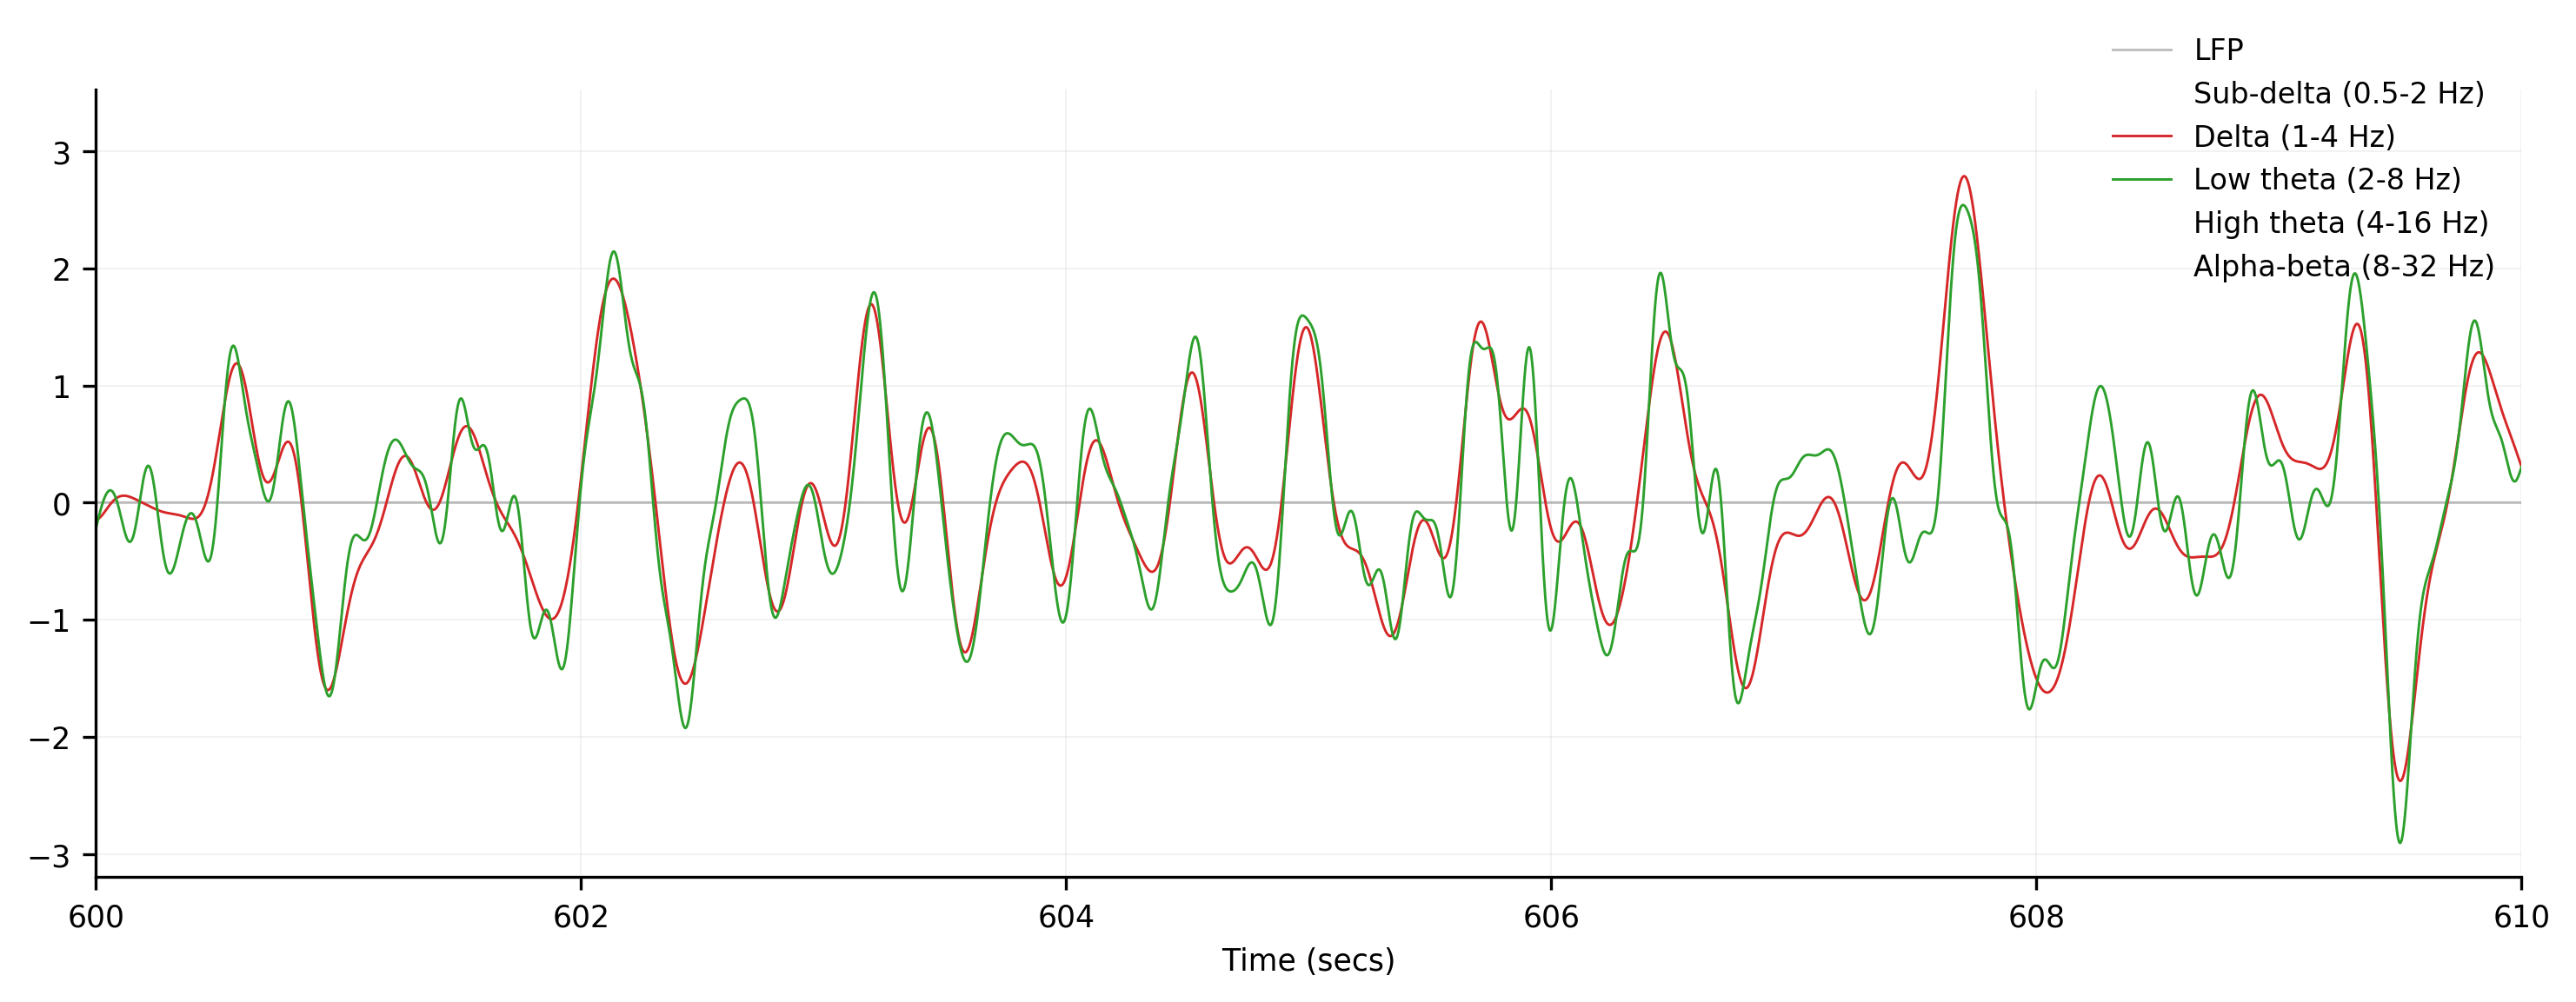

In [75]:
i = 7
dat = np.vstack((lfp_preproc.data[i, :], 
                 lfp_filt['sub_delta'].data[i, :], 
                 lfp_filt['delta'].data[i, :],
                 lfp_filt['low_theta'].data[i, :],
                 lfp_filt['high_theta'].data[i, :],
                 lfp_filt['alpha_beta'].data[i, :]))

fig, ax = plot_trace(dat, start=600, duration=10, x_units='secs', 
                     colors=['C7', 'C0', 'C1', 'C2', 'C3', 'C4'], 
                     alphas=[0.5, 0, 1, 1, 0, 0], 
                     legend_labels=['LFP'] + list(bands_fancy.values()))

In [228]:
nsec = lfp_filt[band].shape[1] / 2000
for band in band_names:
    cycle_inds, phase = phase_locking.interp_phase(lfp_filt[band].data, find='extrema')
    qcycle_inds, qphase = phase_locking.interp_phase(lfp_filt[band].data, find='extrema2')
    
    m = []
    for i in range(64):
        if i == 44:
            continue
        m.append([np.sum(cycle_inds[2]==i)/nsec, np.sum(qcycle_inds[0]==i)/nsec])
    m = np.array(m)
    print(band, np.round(np.mean(m, axis=0), 2))

sub_delta [1.8  1.26]
delta [2.83 1.74]
low_theta [5.15 2.97]
high_theta [9.8  6.47]
alpha_beta [21.51 14.32]


In [1100]:
phase = OrderedDict()
qphase = OrderedDict()
for band in band_names:
    _, phase[band] = phase_locking.interp_phase(lfp_filt[band].data, find='extrema')
    _, qphase[band] = phase_locking.interp_phase(lfp_filt[band].data, find='extrema2')

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b4845eeda90>],
       dtype=object))

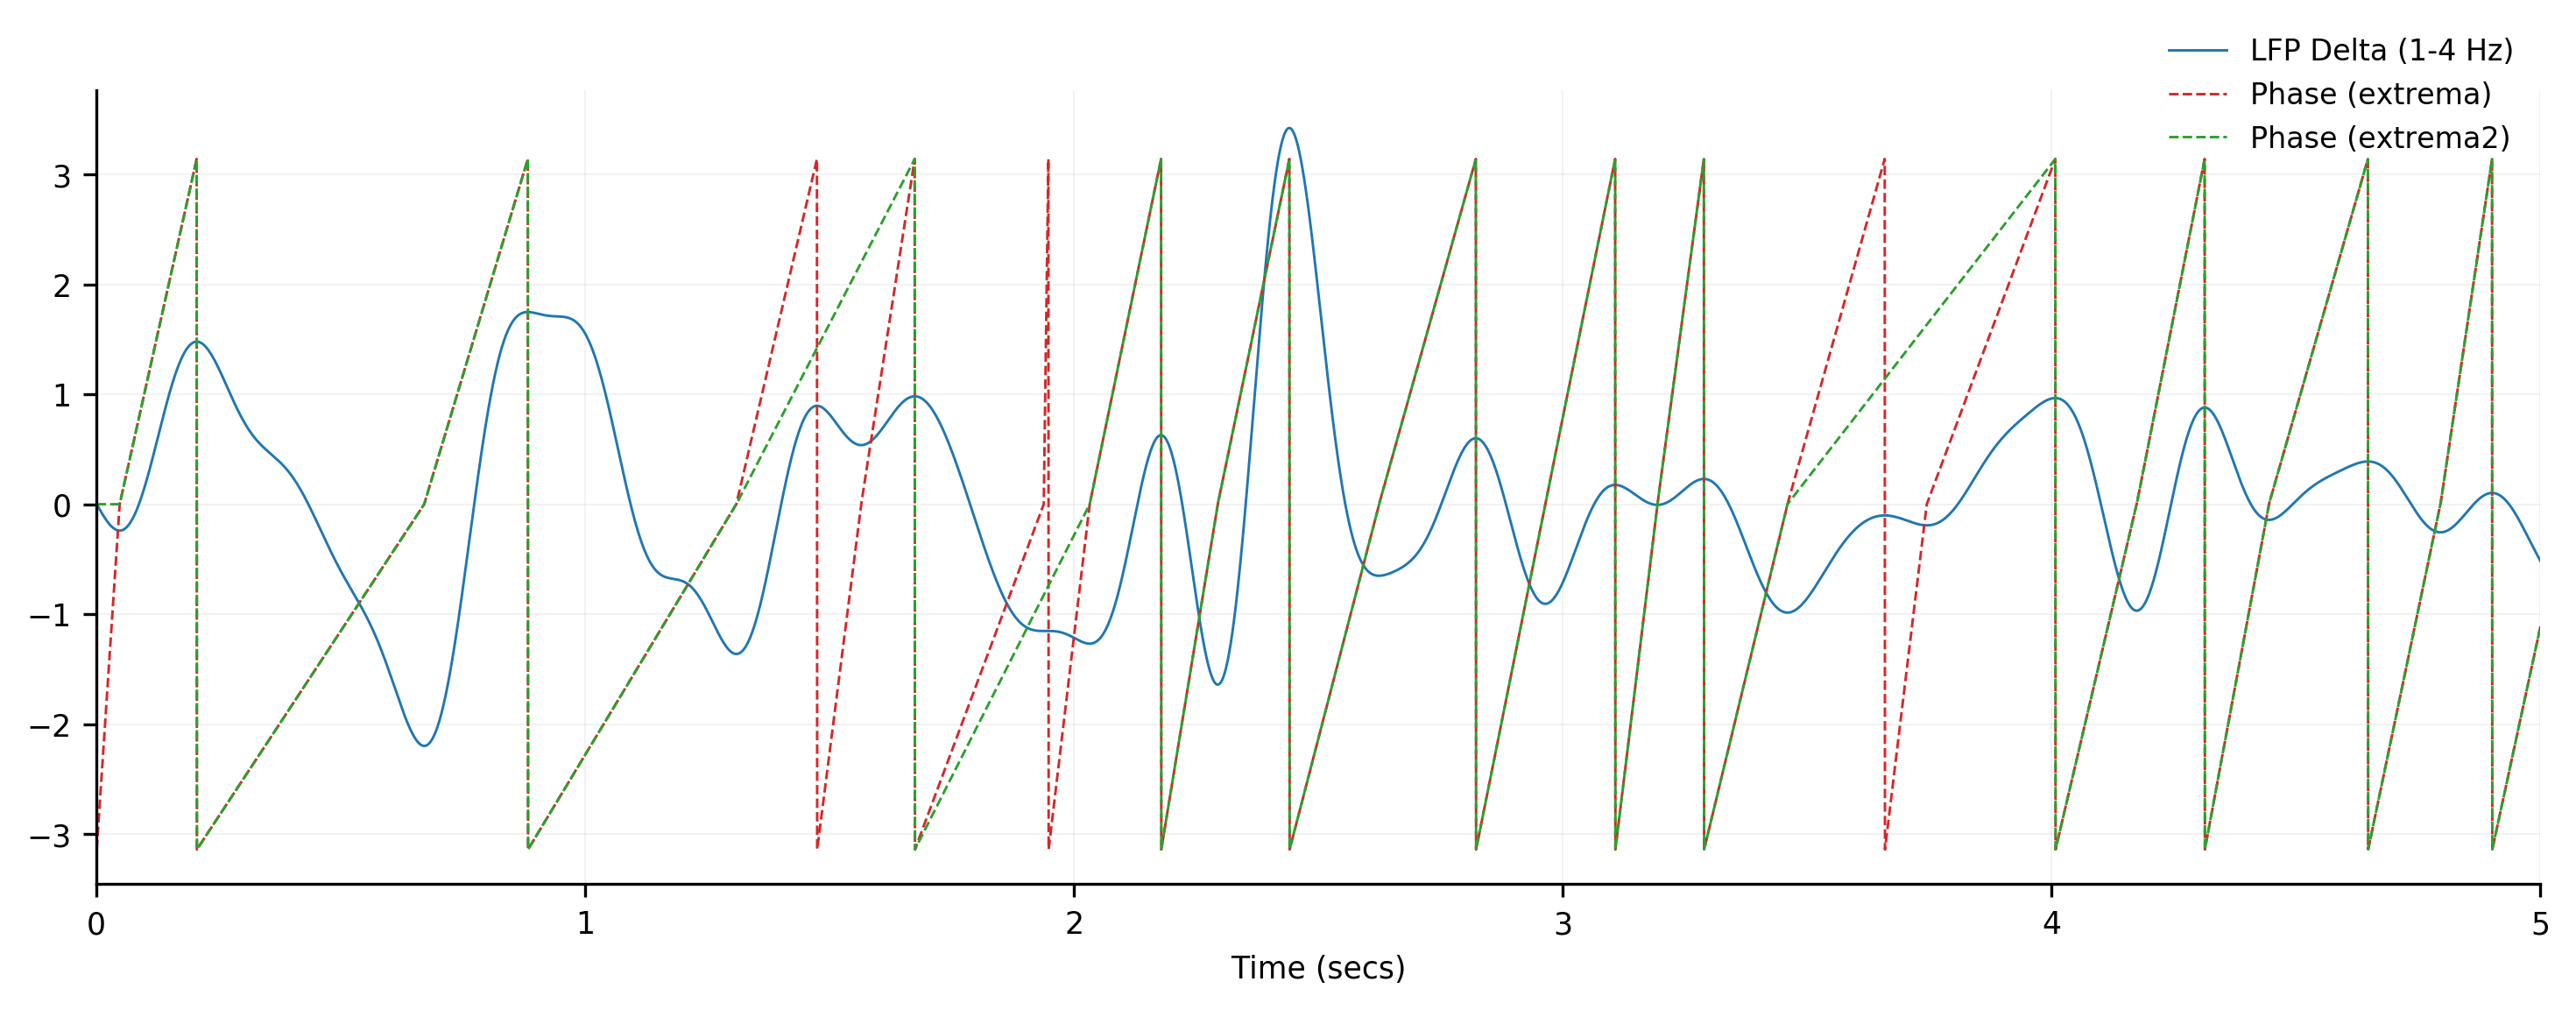

In [1103]:
i = 7
band = 'delta'
plot_trace(np.vstack((stats.zscore(lfp_filt[band][i, :]), phase[band][i, :], qphase[band][i, :])), 
            start=0, duration=5, linestyles=['-', '--', '--'], 
            legend_labels=['LFP {}'.format(bands_fancy[band]), 'Phase (extrema)', 'Phase (extrema2)'])

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b484c05f128>],
       dtype=object))

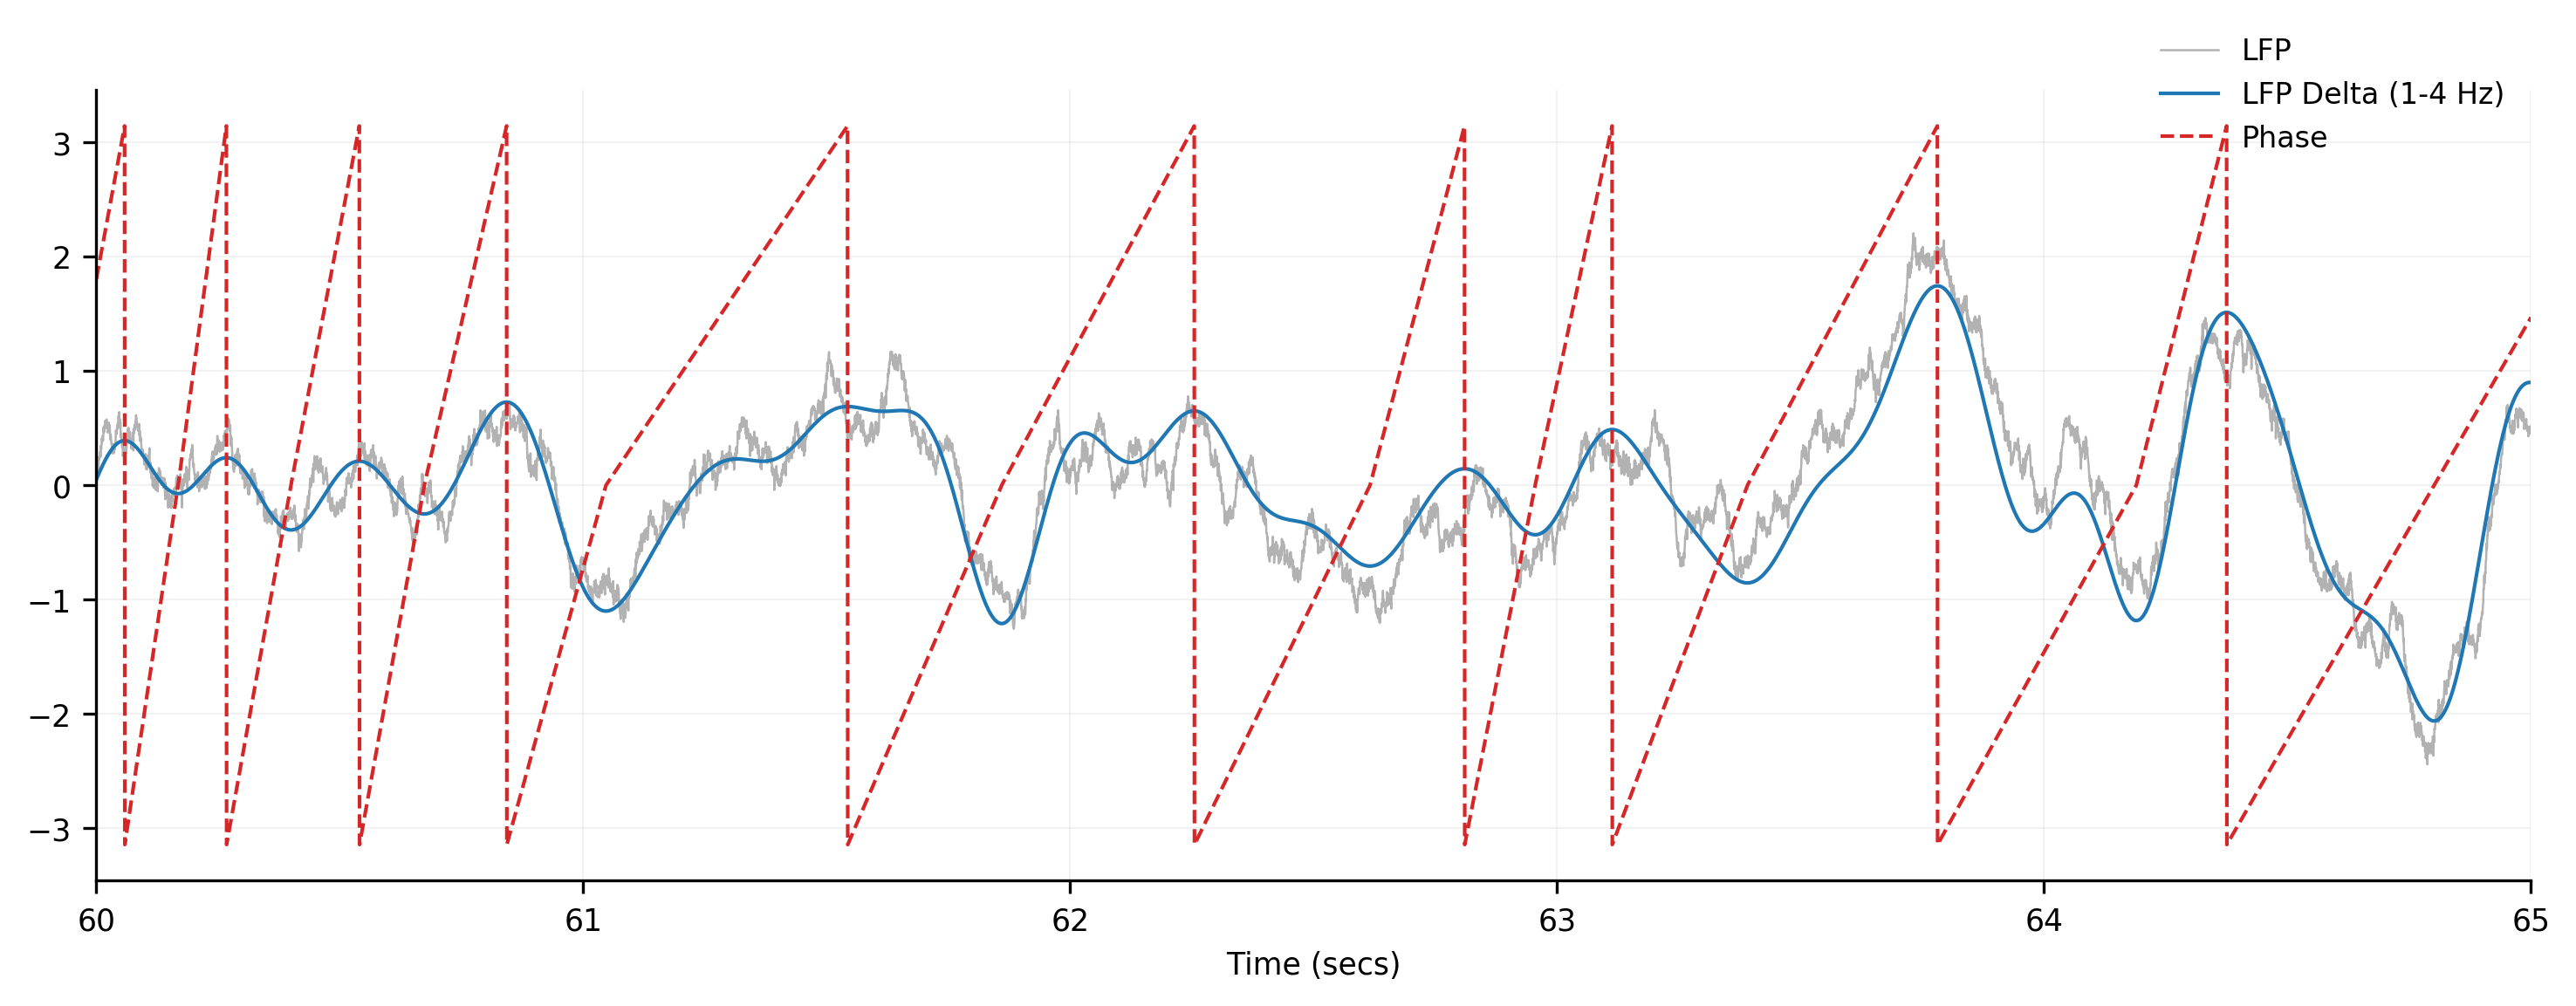

In [1108]:
i = 7
band = 'delta'
plot_trace(np.vstack((stats.zscore(lfp_preproc[i, :]), stats.zscore(lfp_filt[band][i, :]), qphase[band][i, :])), 
            start=60, duration=5, colors=['C7', 'C0', 'C1'], alphas=[0.6, 1, 1], linewidths=[0.6, 1, 1], linestyles=['-', '-', '--'], 
            legend_labels=['LFP', 'LFP {}'.format(bands_fancy[band]), 'Phase'])

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b4847b40f60>],
       dtype=object))

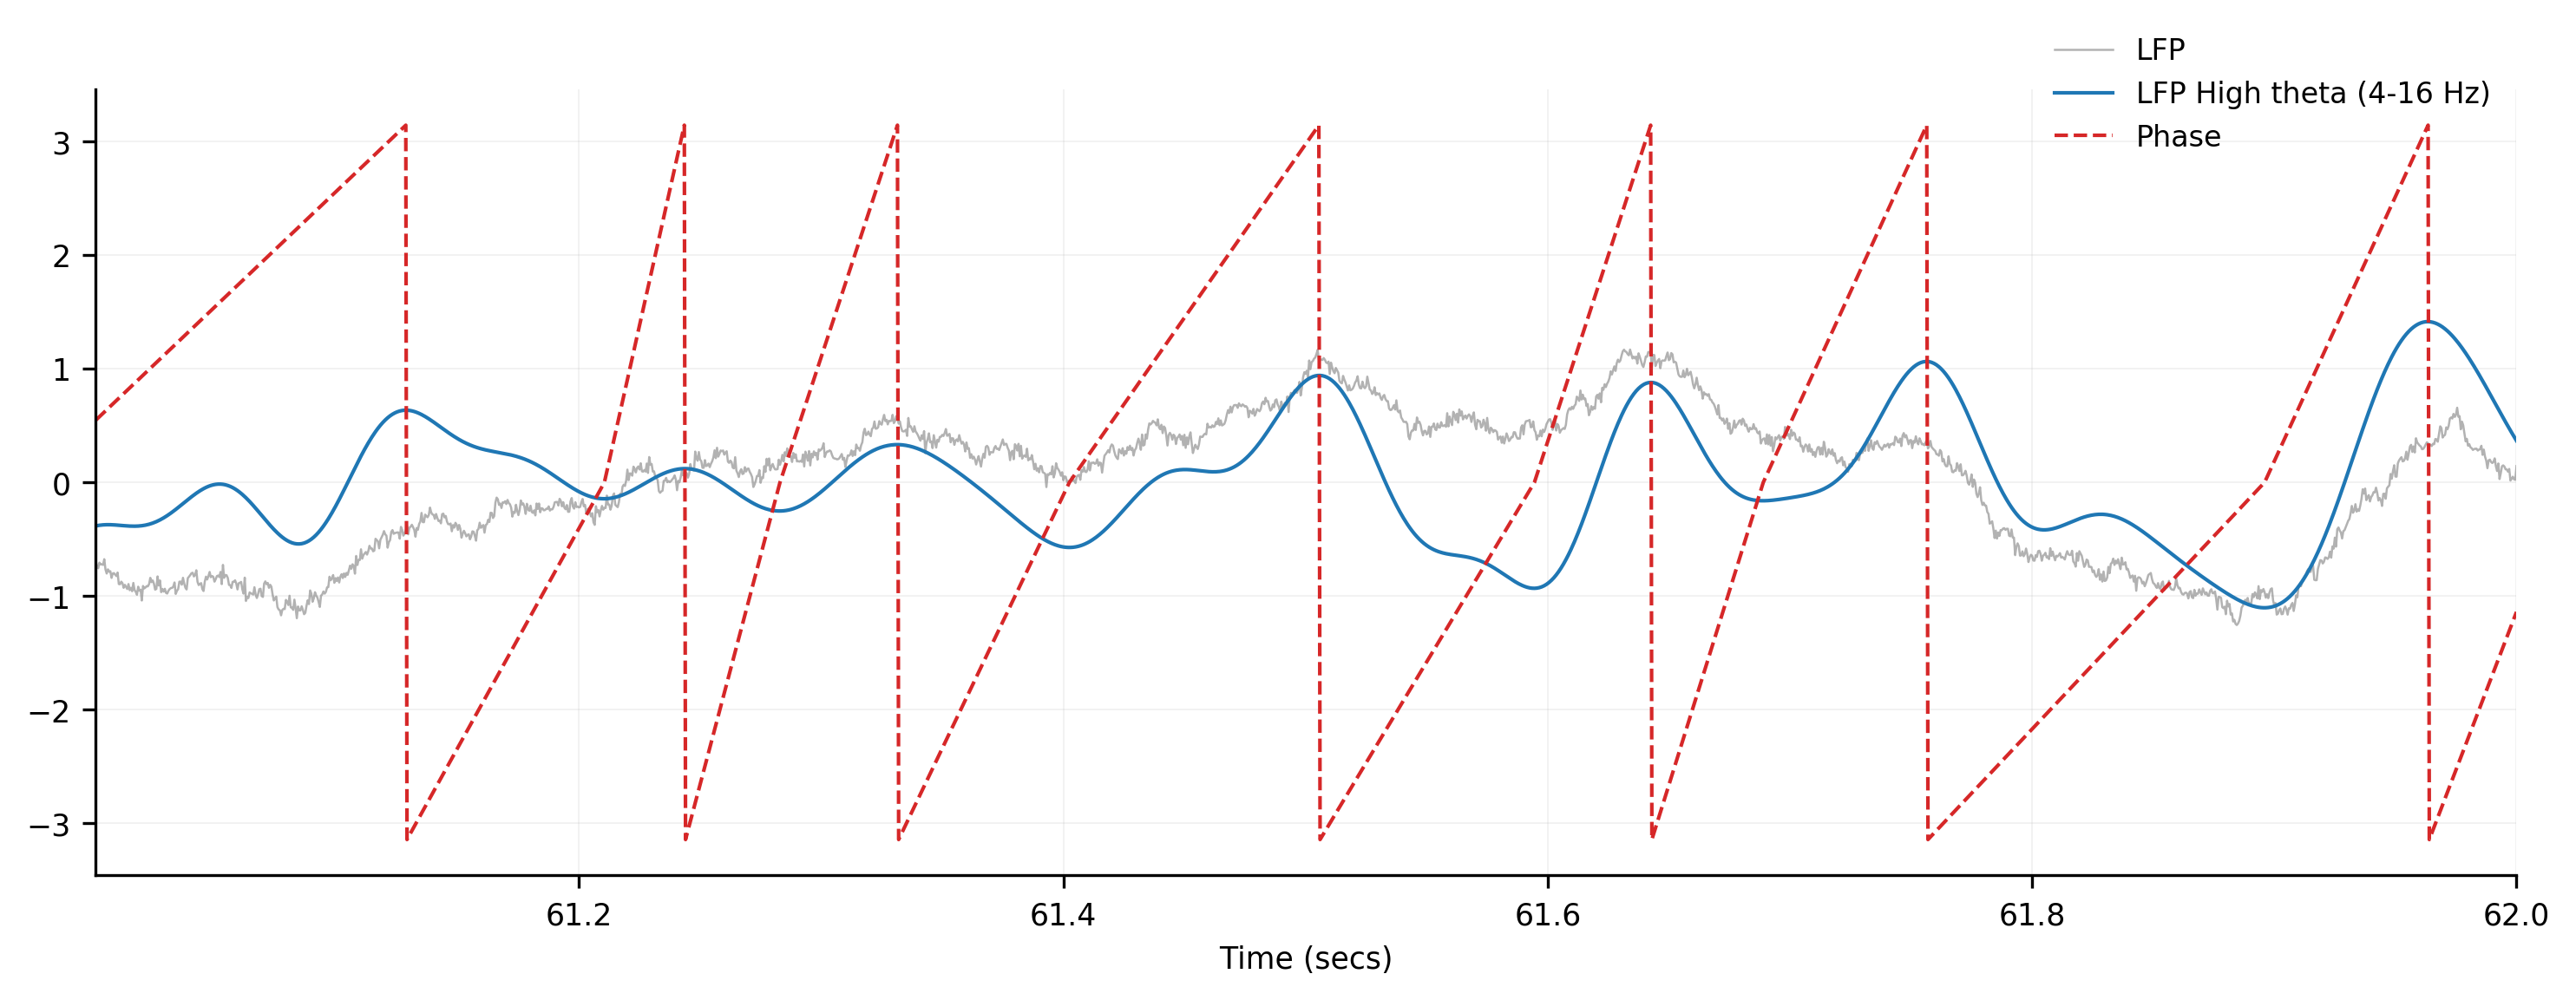

In [1117]:
i = 7
band = 'high_theta'
plot_trace(np.vstack((stats.zscore(lfp_preproc[i, :]), stats.zscore(lfp_filt[band][i, :]), qphase[band][i, :])), 
            start=61, duration=1, colors=['C7', 'C0', 'C1'], alphas=[0.6, 1, 1], linewidths=[0.6, 1, 1], linestyles=['-', '-', '--'], 
            legend_labels=['LFP', 'LFP {}'.format(bands_fancy[band]), 'Phase'])

1.0165543983440188e-157

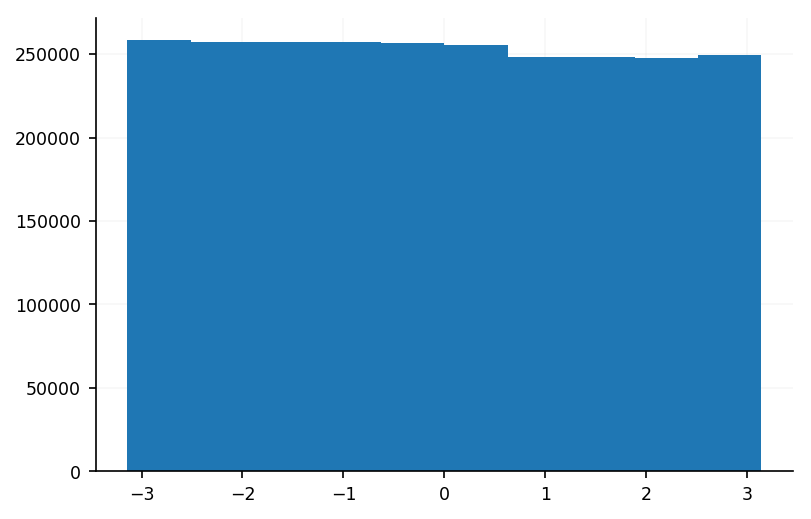

In [248]:
plt.hist(qphase[2, :])
circstats.rayleightest(qphase[2, :])

## Calculate 5-band phase locking

In [14]:
# Params.
bands = OrderedDict([('sub_delta', [0.5, 2]),
                     ('delta', [1, 4]),
                     ('low_theta', [2, 8]),
                     ('high_theta', [4, 16]),
                     ('alpha_beta', [8, 32])])
band_names = list(bands.keys())
bands_fancy = OrderedDict([('sub_delta', 'Sub-delta (0.5-2 Hz)'),
                           ('delta', 'Delta (1-4 Hz)'),
                           ('low_theta', 'Low theta (2-8 Hz)'),
                           ('high_theta', 'High theta (4-16 Hz)'),
                           ('alpha_beta', 'Alpha-beta (8-32 Hz)')])
bands_fancy2 = OrderedDict([('sub_delta', 'Sub-delta'),
                            ('delta', 'Delta'),
                            ('low_theta', 'Low theta'),
                            ('high_theta', 'High theta'),
                            ('alpha_beta', 'Alpha-beta')])

sessions = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
            'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2', 
            'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
            'U371_env2', 'U371_env3']
sessions = np.sort(sessions)

interp_spikes = False
notch_freqs = [60, 120]
phase_type = 'extrema2'
mask_type = None

In [335]:
# Get a list of all unit-to-LFP pairs for each session, in serial.
for subj_sess in sessions:
    ce_df = phase_locking.get_cross_electrode_unit_lfp_pairs(subj_sess)

In [28]:
# Calculate cycle_stats and inter-electrode phase-locking.
for subj_sess in sessions[:1]:
    start_time = time()
#     lfp_filt, phase, power, cycle_stats = phase_locking.get_cycle_stats(subj_sess, 
#                                                                         bands=bands, 
#                                                                         interp_spikes=interp_spikes,
#                                                                         notch_freqs=notch_freqs,
#                                                                         phase_type=phase_type)
    pl_df = phase_locking.calc_cross_electrode_phase_locking(subj_sess, 
                                                             bands=bands, 
                                                             interp_spikes=interp_spikes,
                                                             notch_freqs=notch_freqs,
                                                             phase_type=phase_type,
                                                             mask_type=mask_type,
                                                             hpc_subset=True,
                                                             n_bootstraps=110)
    print('Done in {:.0f} secs'.format(time() - start_time))

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/U369_env1_crosselec_phaselock_df_notch60-120_nospikeinterp_phase-extrema2_nomask_10bootstraps_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl
Done in 194 secs


## Analyze 5-band phase-locking results

In [6]:
def invert_dict(d):
    """Invert a dictionary of string keys and list values."""
    if type(d) == dict:
        newd = {}
    else:
        newd = OrderedDict()
    for k, v in d.items():
        for x in v:
            newd[x] = k
    return newd

In [15]:
# Load all cross-electrode files into a single dataframe.
pl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                             '*_crosselec_phaselock_df_notch60-120_nospikeinterp_phase-extrema2_nomask_10000bootstraps_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
# pl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
#                              '*_crosselec_phaselock_df_notch60-120_nospikeinterp_phase-extrema2_nomask_10000bootstraps_hpc-subset_roll2_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(pl_files)))

pl_df = dio.open_pickle(pl_files[0])
for f in pl_files[1:]:
    pl_df = pl_df.append(dio.open_pickle(f))
pl_df.reset_index(drop=True, inplace=True)
pl_df_ = pl_df.copy()

Found 14 files


In [279]:
# Reset pl_df to factory conditions.
pl_df = pl_df_.copy()

In [280]:
shp = pl_df.shape

# Add higher-level ROI mappings.
hemrois = {'lhpc': ['LAH', 'LMH', 'LPH'],
           'lamy': ['LA'],
           'lec': ['LEC'],
           'lphg': ['LPG'],
           'rhpc': ['RAH', 'RMH', 'RPH'],
           'ramy': ['RA'],
           'rec': ['REC'],
           'rphg': ['RPG']}
hemrois['lctx'] = [roi for roi in sorted(set(pl_df.loc[pl_df.lfp_hem=='L'].lfp_hemroi)) 
                   if roi not in list(itertools.chain(*hemrois.values()))]
hemrois['rctx'] = [roi for roi in sorted(set(pl_df.loc[pl_df.lfp_hem=='R'].lfp_hemroi)) 
                   if roi not in list(itertools.chain(*hemrois.values()))]
hemrois_inv = invert_dict(hemrois)
pl_df['unit_hemroi2'] = pl_df.unit_hemroi.agg(lambda x: hemrois_inv[x])
pl_df['lfp_hemroi2'] = pl_df.lfp_hemroi.agg(lambda x: hemrois_inv[x])

rois = {'hpc': ['AH', 'MH', 'PH'],
        'amy': ['A'],
        'ec': ['EC'],
        'phg': ['PG']}
rois['ctx'] = [roi for roi in sorted(set(pl_df.lfp_roi)) if roi not in list(itertools.chain(*rois.values()))]
rois_inv = invert_dict(rois)
pl_df['unit_roi2'] = pl_df.unit_roi.agg(lambda x: rois_inv[x])
pl_df['lfp_roi2'] = pl_df.lfp_roi.agg(lambda x: rois_inv[x])
pl_df['same_roi2'] = pl_df['unit_roi2'] == pl_df['lfp_roi2']

# Remove inter-hemispheric pairs.
pl_df = pl_df.loc[pl_df.same_hem==True]

# Remove same-channel pairs.
pl_df = pl_df.loc[pl_df.same_chan!=True]

# Remove intra-regional pairs from different microwire bundles.
pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")

# Remove units with <250 spikes.
pl_df['n_spikes'] = np.array([x[0].shape for x in pl_df['spike_inds']])
pl_df = pl_df.loc[pl_df.n_spikes>249]

# Remove bad channels.
# ADD CODE HERE

# Determine the alpha threshold for each unit-LFP pair. Alpha is Bonferroni-corrected
# by the number of channels in a given region that a unit is compared against to
# determine if it is phase-locked to any channel in that region. E.g., for a 
# R entorhinal unit - R amygdala LFP pair, if there are 8 R amygdala LFPs then the
# significance threshold for this pair is alpha/8. Note that when comparing a R amygdala
# unit to a R amygdala LFP, the threshold would be alpha/7 since we removed same-channel pairs.
alpha = 0.01/5 # 5 for the number of bands
pl_df['n_comparisons'] = np.array(pl_df.groupby(['subj_sess', 'lfp_hemroi2', 'unit']).unit_lfpchanind.transform(len).tolist())
pl_df['bonf_alpha'] = alpha / np.array(pl_df.groupby(['subj_sess', 'lfp_hemroi2', 'unit']).unit_lfpchanind.transform(len).tolist())

pl_df.reset_index(drop=True, inplace=True)

print('Shape changed from {} to {}'.format(shp, pl_df.shape))

# Figure out which units are phase-locked to which bands. 
pl_df['pval_argmin'] = pl_df.pvals.apply(lambda x: np.argmin(x))
locked_bands = []
locked_phases = []
locked_lengths = []
locked_pvals = []
for i in range(len(pl_df)):
    locked_bands.append(band_names[pl_df.at[i, 'pval_argmin']])
    locked_phases.append(pl_df.at[i, 'means'][pl_df.at[i, 'pval_argmin']])
    locked_lengths.append(pl_df.at[i, 'lengths'][pl_df.at[i, 'pval_argmin']])
    locked_pvals.append(pl_df.at[i, 'pvals'][pl_df.at[i, 'pval_argmin']])
pl_df['locked_band'] = np.array(locked_bands)
pl_df['locked_phase'] = np.array(locked_phases)
pl_df['locked_length'] = np.array(locked_lengths)
pl_df['locked_pval'] = np.array(locked_pvals)
pl_df['sig'] = pl_df.locked_pval < pl_df.bonf_alpha

Shape changed from (40488, 25) to (20676, 33)


In [419]:
# Caculate mean resultant length and Rayleigh p-value
# by hand from a vector of phases.

nspikes = len(pl_df.at[0, 'spike_inds'][0])
v = pl_df.at[0, 'spike_phases'][0]

rl = np.sqrt(np.sum(np.cos(v))**2 + np.sum(np.sin(v))**2)
mrl = rl / nspikes
print('Calculations by hand\n--------------------')
print('Mean resultant length: {}, {}\n'.format(circstats.circmoment(v)[1], mrl))
print('Rayleigh p-value: {}, {}'.format(circstats.rayleightest(v), np.e**-(rl**2 / nspikes)))

Calculations by hand
--------------------
Mean resultant length: 0.018853193552909382, 0.018853193552909382

Rayleigh p-value: 0.10230356006167657, 0.10230356006167662


In [821]:
# TROUBLESHOOTING

pl_df.loc[72]
# U390_ses3, unit 3 (chan ind 5), lfp_chan_ind 3 (RAH to RAH)

subj_sess = 'U390_ses3'
notch_freqs=[60, 120]
zscore_lfp=True
zscore_power=True
phase_type='extrema2'
power_percentile=25
osc_length=3
mask_type=None
roll10=False
save_outputs=False
############################

# Get session info.
subj_df = phase_locking.get_subj_df()

# Load spikes.
spikes, fr_df, clus_to_chan, chan_to_clus = phase_locking.load_spikes(subj_sess)
units = fr_df.clus.tolist()

# # Load the raw LFP.
# ms_before = 2
# ms_after = 4
# lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
#                                                     subj_df=subj_df, 
#                                                     notch_freqs=notch_freqs,
#                                                     interpolate=interp_spikes,
#                                                     session_spikes=spikes,
#                                                     ms_before=ms_before,
#                                                     ms_after=ms_after)
# sampling_rate = lfp_preproc.samplerate.data.tolist()

# # Bandpass filter the LFP.
# lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
#                                 bands=bands, 
#                                 zscore_lfp=zscore_lfp)

# # Use a derivative test to identify troughs and peaks in the filtered 
# # LFP, then linearly interpolate phase between cycles.
# if phase_type == 'hilbert':
#     phase_type_ = 'peaks'
# else:
#     phase_type_ = phase_type

# phase = phase_locking.get_phase_bands(lfp_filt, 
#                                       bands=bands, 
#                                       find=phase_type_, 
#                                       lims=[-np.pi, np.pi])

0.00017603158063093656

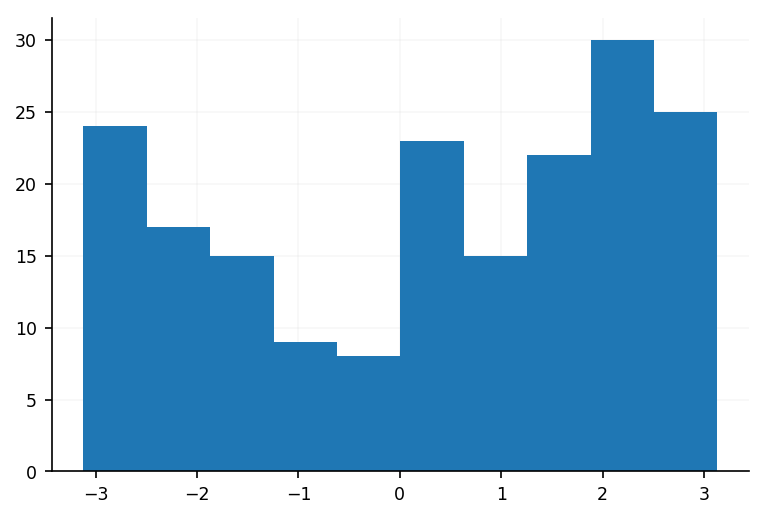

In [282]:
plt.hist(pl_df.loc[72, 'spike_phases'][1])
circstats.rayleightest(pl_df.loc[72, 'spike_phases'][1])

## Initial phase-locking analysis

In [279]:
# What percent of unit->LFP pairs show significant phase-locking?
print('All pairs:', np.sum(pl_df.sig)/len(pl_df))
print('Within-bundle:', np.sum(pl_df.loc[pl_df.same_roi2==True, 'sig']) / len(pl_df.loc[pl_df.same_roi2==True, 'sig']))
print('Between-region:', np.sum(pl_df.loc[pl_df.same_roi2==False, 'sig']) / len(pl_df.loc[pl_df.same_roi2==False, 'sig']))

All pairs: 0.22757434259031703
Within-bundle: 0.3240418118466899
Between-region: 0.13349514563106796


In [289]:
# What percent of extra-hippocampal units are phase-locked
# to any frequency, within and between region?
(pl_df.query("(unit_is_hpc==False)")
 .groupby(['subj_sess', 'unit', 'same_roi2'])
 .agg({'n_comparisons': len,
       'sig': np.sum})
 .reset_index()
 .groupby(['same_roi2'])
 .agg({'unit': len,
       'sig': lambda x: np.sum(x>0)/len(x)}))

,unit,sig
same_roi2,,
False,448,0.323661
True,459,0.596950


In [280]:
# What percent of extra-hippocampal units are phase-locked
# to any frequency, within and between region?
(pl_df.query("(unit_is_hpc==False)")
 .groupby(['subj_sess', 'unit', 'same_roi2'])
 .agg({'n_comparisons': len,
       'sig': np.sum})
 .reset_index()
 .groupby(['subj_sess', 'same_roi2'])
 .agg({'unit': len,
       'sig': lambda x: np.sum(x>0)/len(x)}))

unit       sig
subj_sess same_roi2                
U369_env1 False        51  0.274510
          True         51  0.549020
U369_env2 False        33  0.151515
          True         33  0.606061
U371_env2 False        31  0.645161
          True         31  0.612903
U371_env3 False        48  0.291667
          True         48  0.562500
U372_ses2 False        27  0.370370
          True         27  0.777778
U373_ses1 False        38  0.184211
          True         49  0.428571
U380_ses2 False        53  0.169811
          True         53  0.660377
U384_ses3 False        42  0.238095
          True         42  0.619048
U385_ses4 False        26  0.307692
          True         26  0.500000
U387_ses1 False        18  0.555556
          True         18  0.777778
U387_ses3 False        18  0.555556
          True         18  0.722222
U390_ses3 False         6  0.500000
          True          6  0.833333
U393_ses2 False        31  0.451613
          True         31  0.516129
U395_ses2 False        26  0.423077
          True         26  0.615385

In [281]:
# What percent of units in each region are phase-locked
# to that region, at any frequency?
(pl_df.query("(lfp_is_hpc==False) | ((unit_is_hpc==True) & (lfp_is_hpc==True))")
 .groupby(['subj_sess', 'unit', 'unit_roi2', 'lfp_roi2'])
 .agg({'n_comparisons': len,
       'sig': np.sum})
 .reset_index()
 .groupby(['unit_roi2'])
 .agg({'unit': len,
       'sig': lambda x: np.sum(x>0)/len(x)}))

,unit,sig
unit_roi2,,
amy,136,0.654412
ctx,169,0.674556
ec,77,0.415584
hpc,115,0.756522
phg,77,0.506494


In [282]:
# What percent of units in each region are phase-locked
# to the hippocampus, at any frequency?
(pl_df.query("(unit_is_hpc==False) & (lfp_is_hpc==True)")
 .groupby(['subj_sess', 'unit', 'unit_roi2', 'lfp_roi2'])
 .agg({'n_comparisons': len,
       'sig': np.sum})
 .reset_index()
 .groupby(['unit_roi2'])
 .agg({'unit': len,
       'sig': lambda x: np.sum(x>0)/len(x)}))

,unit,sig
unit_roi2,,
amy,127,0.574803
ctx,169,0.130178
ec,75,0.426667
phg,77,0.233766


In [285]:
# Among phase-locked units, what frequency?
df = (pl_df.query("(sig==True) & (unit_is_hpc==False)")
 .groupby(['subj_sess', 'unit', 'unit_roi2', 'lfp_roi2', 'lfp_is_hpc', 'locked_band'])
 .agg({'n_comparisons': len})
 .reset_index()
 .groupby(['lfp_is_hpc', 'locked_band'])
 .agg({'n_comparisons': len}).n_comparisons.unstack())
df = df.iloc[:, [4, 1, 3, 2, 0]]
df

locked_band,sub_delta,delta,low_theta,high_theta,alpha_beta
lfp_is_hpc,,,,,
0,54,59,95,124,108
1,62,63,66,50,7


In [288]:
# Among phase-locked units, what frequency?
(pl_df.query("(sig==True)")
 .groupby(['subj_sess', 'unit', 'unit_roi2', 'lfp_roi2', 'lfp_is_hpc', 'locked_band'])
 .agg({'n_comparisons': len})
 .reset_index()
 .groupby(['lfp_is_hpc', 'unit_roi2', 'locked_band'])
 .agg({'n_comparisons': len}).unstack().iloc[:, [4, 1, 3, 2, 0]])

n_comparisons                                      
locked_band              sub_delta delta low_theta high_theta alpha_beta
lfp_is_hpc unit_roi2                                                    
0          amy                30.0  25.0      25.0       31.0       32.0
           ctx                 8.0  17.0      45.0       64.0       56.0
           ec                  7.0   5.0       9.0       16.0       10.0
           phg                 9.0  12.0      16.0       13.0       10.0
1          amy                36.0  39.0      38.0       27.0        3.0
           ctx                 8.0   7.0       8.0        6.0        NaN
           ec                  7.0  11.0      17.0       16.0        4.0
           hpc                39.0  45.0      49.0       15.0       31.0
           phg                11.0   6.0       3.0        1.0        NaN

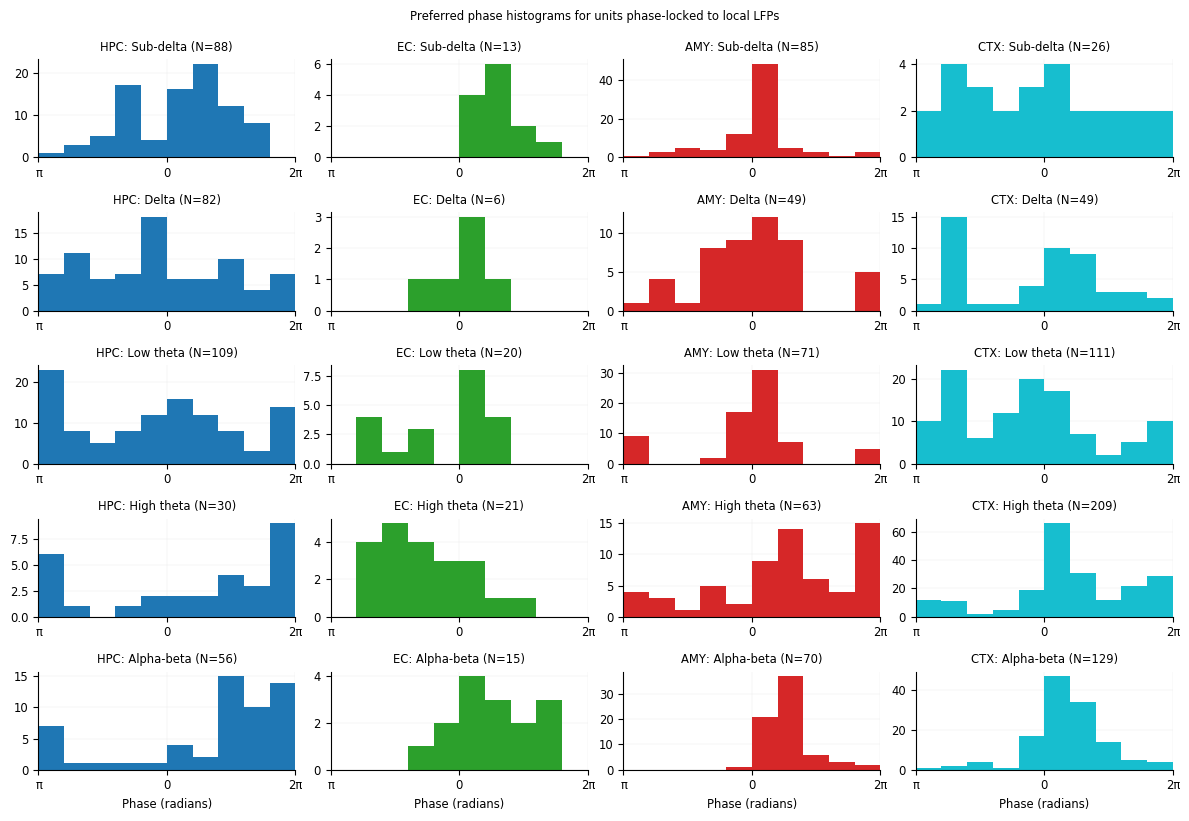

In [441]:
# Preferred phase of phase-locked units
fig, ax = plt.subplots(5, 4, sharex=False, figsize=(12, 8), dpi=100)
ax = np.ravel(ax)

for x, band_name in enumerate(band_names):  
    v = pl_df.query("(sig==True) & (unit_roi2=='hpc') & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C0')
    ax[4*x].set_title('HPC: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    
    v = pl_df.query("(sig==True) & (unit_roi2=='ec') & (lfp_is_hpc==False) & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x+1].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C2')
    ax[4*x+1].set_title('EC: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    
    v = pl_df.query("(sig==True) & (unit_roi2=='amy') & (lfp_is_hpc==False) & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x+2].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C1')
    ax[4*x+2].set_title('AMY: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    
    v = pl_df.query("(sig==True) & (unit_roi2==['ctx', 'phg']) & (lfp_is_hpc==False) & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x+3].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C9')
    ax[4*x+3].set_title('CTX: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    
for i in range(len(ax)):
    ax[i].set_xlim([-np.pi, np.pi])
    ax[i].set_xticks([0, -np.pi, np.pi])
    ax[i].set_xticklabels([0, 'π', '2π'])
    if i >= len(ax)-4:
        ax[i].set_xlabel('Phase (radians)')
        
fig.suptitle('Preferred phase histograms for units phase-locked to local LFPs', y=1.02)   
fig.tight_layout(w_pad=0, h_pad=1)

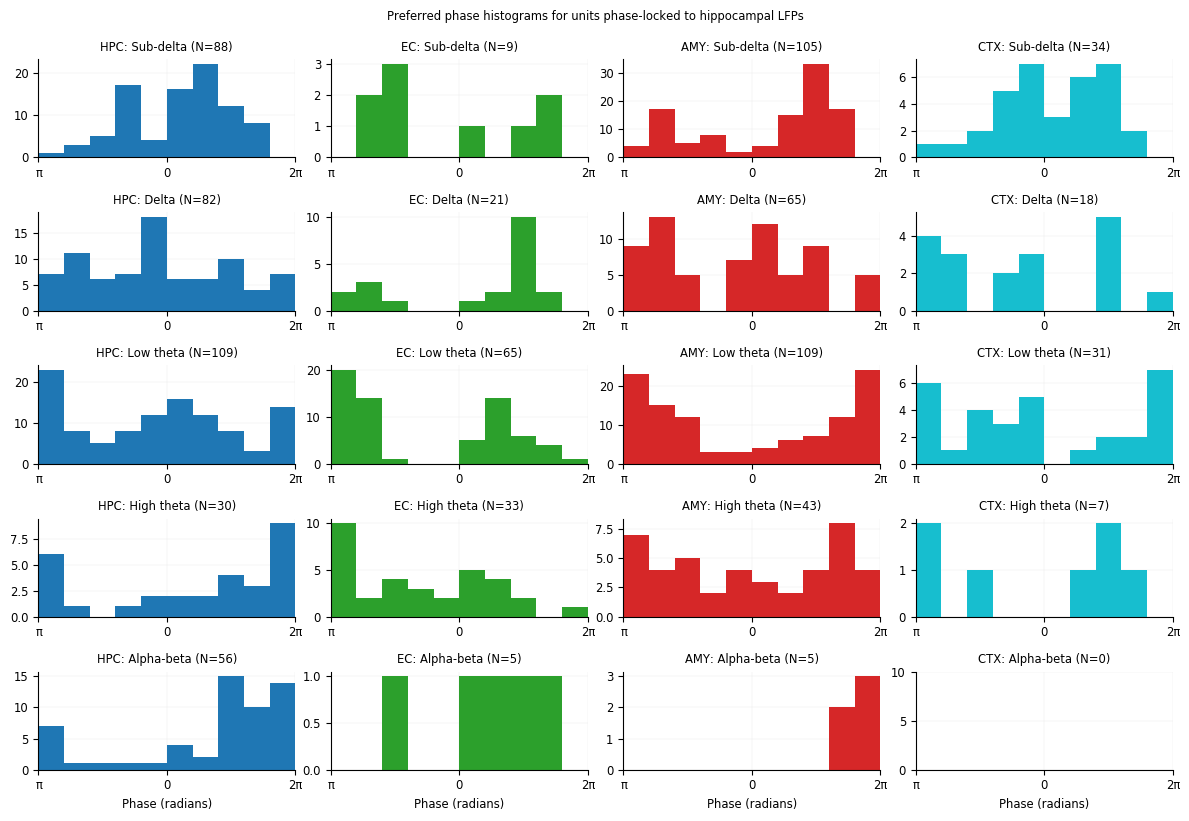

In [440]:
# Preferred phase of phase-locked units
fig, ax = plt.subplots(5, 4, sharex=False, figsize=(12, 8), dpi=100)
ax = np.ravel(ax)

for x, band_name in enumerate(band_names):
    v = pl_df.query("(sig==True) & (unit_roi2=='hpc') & (lfp_is_hpc==True) & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C0')
    ax[4*x].set_title('HPC: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    
    v = pl_df.query("(sig==True) & (unit_roi2=='ec') & (lfp_is_hpc==True) & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x+1].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C2')
    ax[4*x+1].set_title('EC: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    
    v = pl_df.query("(sig==True) & (unit_roi2=='amy') & (lfp_is_hpc==True) & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x+2].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C1')
    ax[4*x+2].set_title('AMY: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    
    v = pl_df.query("(sig==True) & (unit_roi2==['ctx', 'phg']) & (lfp_is_hpc==True) & (locked_band=='{}')".format(band_name)).locked_phase
    ax[4*x+3].hist(v, bins=np.linspace(-np.pi, np.pi, 11), color='C9')
    ax[4*x+3].set_title('CTX: {} (N={})'.format(bands_fancy2[band_name], len(v)))
    if len(v) == 0:
        ax[4*x+3].set_ylim(0, 10)
        ax[4*x+3].set_yticks([0, 5, 10])
    
for i in range(len(ax)):
    ax[i].set_xlim([-np.pi, np.pi])
    ax[i].set_xticks([0, -np.pi, np.pi])
    ax[i].set_xticklabels([0, 'π', '2π'])
    if i >= len(ax)-4:
        ax[i].set_xlabel('Phase (radians)')
        
fig.suptitle('Preferred phase histograms for units phase-locked to hippocampal LFPs', y=1.02)   
fig.tight_layout(w_pad=0, h_pad=1)

## Nora's MRL phase-locking method

In [253]:
reload(phase_locking)

<module 'phase_locking' from '/home1/dscho/code/projects/unit_activity_and_hpc_theta/phase_locking.py'>

In [254]:
start_time = time()
subj_sess = 'U387_ses3'
upl_df = phase_locking.calc_cross_electrode_phase_locking_mrl(subj_sess,
                                                              bands=bands, 
                                                              interp_spikes=interp_spikes,
                                                              notch_freqs=notch_freqs,
                                                              phase_type=phase_type,
                                                              mask_type=mask_type,
                                                              hpc_subset=True,
                                                              n_bootstraps=1000)
print('Done in {:.0f} secs'.format(time() - start_time))

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/U387_ses3_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_1000bootstraps_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl
Done in 3067 secs


In [262]:
pl_df.columns

Index(['subj_sess', 'subj_sess_unit', 'unit', 'unit_chan', 'unit_chan_ind',
       'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_is_hpc', 'unit_nspikes',
       'unit_fr', 'lfp_chan', 'lfp_chan_ind', 'lfp_hemroi', 'lfp_hem',
       'lfp_roi', 'lfp_is_hpc', 'same_chan', 'same_hemroi', 'same_hem',
       'same_roi', 'both_hpc', 'unit_hemroi2', 'lfp_hemroi2', 'unit_roi2',
       'lfp_roi2', 'same_roi2', 'spike_inds', 'spike_phases', 'means',
       'lengths', 'pvals', 'pval_argmin', 'locked_band', 'locked_phase',
       'locked_length', 'locked_pval', 'bs_pval_vec', 'bs_pval_ind', 'bs_pval',
       'n_comparisons', 'bonf_alpha', 'sig', 'mrls'],
      dtype='object')

In [265]:
(pl_df.query("(subj_sess=='{}')".format(subj_sess))
 .groupby(['subj_sess_unit', 'lfp_is_hpc'])
 .sig.apply(lambda x: np.sum(x)>0)
 .groupby('lfp_is_hpc').mean())

lfp_is_hpc
0    0.722222
1    0.615385
Name: sig, dtype: float64

In [268]:
upl_df.groupby('lfp_is_hpc').sig.mean()

lfp_is_hpc
0    0.833333
1    0.807692
Name: sig, dtype: float64

In [307]:
df = (pl_df.query("(subj_sess=='{}')".format(subj_sess))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .agg({'sig': np.median,
            'bonf_alpha': np.median,
            'bs_pval': np.median,
            'locked_band': lambda x: np.unique(x, return_counts=True)})
      .reset_index())

In [297]:
upl_df['locked_band'] = upl_df.apply(lambda x: band_names[x['mrl_argmax']], axis=1)
upl_df['locked_mrl'] = upl_df.apply(lambda x: x['mrls'][x['mrl_argmax']], axis=1)

['sub_delta', 'delta', 'low_theta', 'high_theta', 'alpha_beta']

In [308]:
pd.merge(upl_df, df, on=['subj_sess_unit', 'lfp_is_hpc'], how='left')[['subj_sess_unit', 'unit_roi2', 'lfp_roi2', 'locked_band_x', 'locked_band_y', 'locked_mrl', 'sig_x', 'sig_y', 'bs_pval_x', 'bs_pval_y', 'bonf_alpha']]

,subj_sess_unit,unit_roi2,lfp_roi2,locked_band_x,locked_band_y,locked_mrl,sig_x,sig_y,bs_pval_x,bs_pval_y,bonf_alpha
0,U387_ses3_0,ctx,ctx,alpha_beta,"([alpha_beta, delta, high_theta, low_theta, su...",0.018865,False,False,0.144855,1.000000,0.001429
1,U387_ses3_0,ctx,hpc,sub_delta,"([delta, sub_delta], [1, 7])",0.066265,True,False,0.000999,0.075292,0.001250
2,U387_ses3_1,amy,amy,high_theta,"([alpha_beta, high_theta, sub_delta], [3, 2, 2])",0.054949,True,True,0.000999,0.000100,0.001429
3,U387_ses3_1,amy,hpc,low_theta,"([alpha_beta, delta, low_theta, sub_delta], [1...",0.038012,True,True,0.000999,0.000100,0.001250
4,U387_ses3_10,hpc,hpc,low_theta,"([high_theta, low_theta], [3, 4])",0.073539,True,True,0.000999,0.000100,0.001429
5,U387_ses3_11,hpc,hpc,alpha_beta,"([alpha_beta, sub_delta], [3, 4])",0.056903,True,False,0.000999,0.011499,0.001429
6,U387_ses3_12,hpc,hpc,high_theta,"([alpha_beta, delta, high_theta], [2, 2, 3])",0.059771,True,False,0.000999,0.020398,0.001429
7,U387_ses3_13,hpc,hpc,low_theta,"([alpha_beta, delta, low_theta, sub_delta], [2...",0.080735,True,True,0.000999,0.001000,0.001429
8,U387_ses3_15,hpc,hpc,low_theta,"([alpha_beta, low_theta, sub_delta], [2, 3, 2])",0.065489,True,True,0.000999,0.000100,0.001429
9,U387_ses3_16,hpc,hpc,sub_delta,"([alpha_beta, delta, high_theta, sub_delta], [...",0.084214,True,True,0.000999,0.000700,0.001429


In [285]:
upl_df.shape

(44, 16)

In [178]:
m = []
for i in range(5):
    m_ = []
    for ii in range(10):
        m_.append(i + ((i+1) * ii))
    m.append(m_)
m = np.array(m)/50
m.shape

(5, 10)

In [46]:
pl_df['mrls'] = pl_df.lengths.apply(lambda x: np.array(x))

In [180]:
df = pl_df.copy()

In [181]:
df['bs_mrls'] = [m for i in range(len(pl_df))]

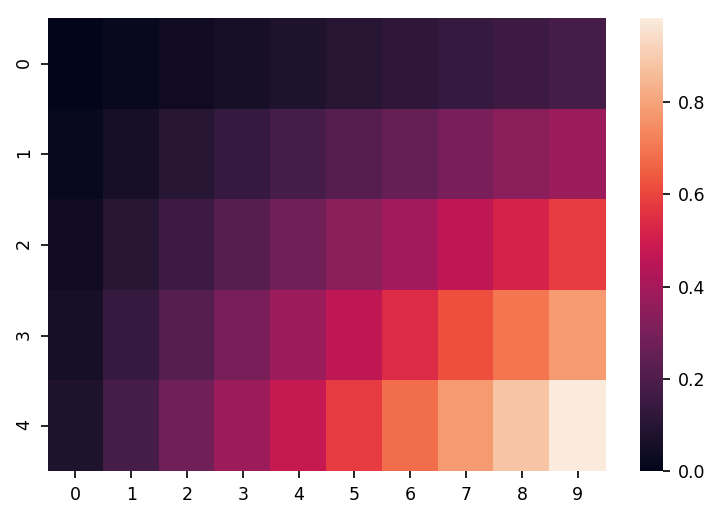

In [186]:
sns.heatmap(df.bs_mrls[0])

In [210]:
upl_df = (df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 
                      'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                      'unit_fr', 'unit_nspikes'])
            .agg({'mrls': lambda x: tuple(np.mean(x)),
                  'bs_mrls': lambda x: tuple(np.mean(x))})
            .reset_index())
upl_df['mrls'] = upl_df.mrls.apply(lambda x: np.array(x))
upl_df['bs_mrls'] = upl_df.bs_mrls.apply(lambda x: np.array(x))
upl_df['mrl_argmax'] = upl_df.mrls.apply(np.argmax)
upl_df['bs_ind'] = upl_df.apply(lambda x: np.sum(x['bs_mrls'][x['mrl_argmax'], :] 
                                                 >= x['mrls'][x['mrl_argmax']]), axis=1)
upl_df['bs_pval'] = upl_df.apply(lambda x: (1 + np.sum(x['bs_mrls'][x['mrl_argmax'], :] 
                                                       >= x['mrls'][x['mrl_argmax']])) / (1 + n_bootstraps), axis=1)

In [227]:
arr = np.array(pl_df.locked_length.tolist())

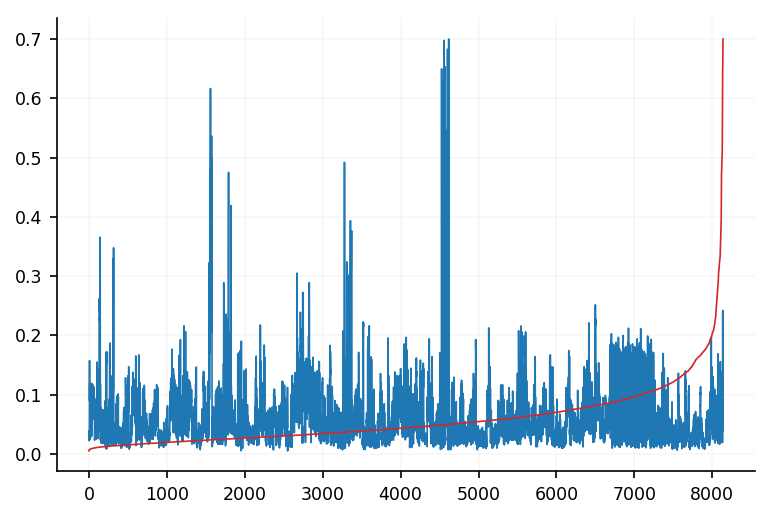

In [228]:
plt.plot(arr)
plt.plot(np.sort(arr))

In [222]:
arr = np.array(upl_df.apply(lambda x: x['mrls'][x['mrl_argmax']], axis=1).tolist())

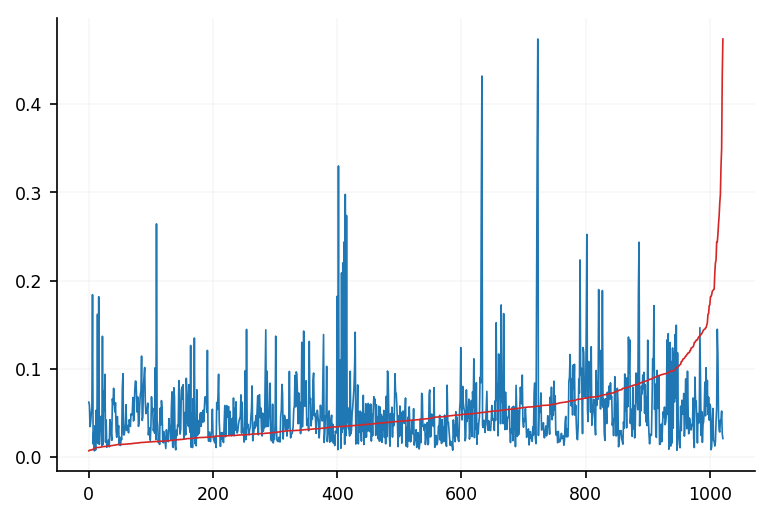

In [226]:
plt.plot(arr)
plt.plot(np.sort(arr))

## Phase-locking frequency: local vs. HPC

In [497]:
# Figure out which extra-hippocampal units have connections 
# to both local and hippocampal LFPs (really just the latter). 
s = (pl_df.query("(unit_roi2!='hpc')")
     .groupby(['subj_sess_unit', 'lfp_is_hpc'])
     .size()
     .groupby('subj_sess_unit')
     .size()>1)
ehip_units = list(s[s].index)

In [545]:
# Are units that are phase-locked to local LFPs more likely
# to be phase-locked to hippocampal LFPs?
df = (pl_df.query("(subj_sess_unit=={})".format(ehip_units))
           .groupby(['subj_sess', 'unit', 'same_roi2'])
           .agg({'n_comparisons': len,
                 'sig': np.sum})
           .reset_index()
           .groupby(['same_roi2'])
           .agg({'unit': len,
                 'sig': lambda x: np.sum(x>0)/len(x)}))
nunits = df.loc[False].unit
p_local = df.loc[False].sig
p_hpc = df.loc[True].sig

exp_both = nunits * (p_local*p_hpc)
exp_either = ((nunits*p_local) - exp_both) + ((nunits*p_hpc) - exp_both)
exp_neither = nunits * (1-p_local) * (1-p_hpc)
print('Phase-locked to: [nothing, local OR hpc, local AND hpc], n_units')
print('Exp:', [int(x) for x in np.round([exp_neither, exp_either, exp_both], 0)], int(exp_neither+exp_either+exp_both))

# Figure out which extra-hippocampal units are phase-locked
# to both local and hippocampal oscillations
s = (pl_df.query("(subj_sess_unit=={})".format(ehip_units))
          .groupby(['subj_sess_unit', 'lfp_is_hpc'])
          .agg({'unit': len,
                'sig': lambda x: np.sum(x)>0})
          .groupby('subj_sess_unit')
          .sig.sum())
pl2_units = list(s[s==2].index)

# Get the number of units phase-locked to local OR hpc,
# local AND hpc, or neither
obs = np.unique(s, return_counts=True)
print('Obs:', obs[1], np.sum(obs[1]))

Phase-locked to: [nothing, local OR hpc, local AND hpc], n_units
Exp: [120, 241, 88] 448
Obs: [139 202 107] 448


In [587]:
# Fancy lambda functions for pandas aggregation.
def get_str_mode(x):
    """x is a list of strings; return the most common string."""
    unq = np.unique(x, return_counts=True)
    return unq[0][unq[1].argmax()]

def band_comp(x):
    assert len(x) == 2
    if x[0] < x[1]:
        return 'hpc_is_higher'
    elif x[0] == x[1]:
        return 'same_band'
    else:
        return 'hpc_is_lower'

In [671]:
# For units phase-locked to both local and hippocampal LFPs,
# is the hippocampal band at a lower, same, or higher frequency?
df = (pl_df.query("(sig==True) & (subj_sess_unit=={})".format(pl2_units))
           .groupby(['subj_sess_unit', 'lfp_is_hpc'])
           .agg({'unit': len,
                 'sig': np.sum,
                 'locked_band': get_str_mode}))
#lambda x: np.unique(x, return_counts=True) 
df['locked_band_ind'] = df.locked_band.apply(lambda x: band_names.index(x))
s = df.groupby('subj_sess_unit').locked_band_ind.apply(band_comp)
unq = np.unique(s, return_counts=True)
print(unq)

df = df.locked_band_ind.unstack()
df.rename(columns={0: 'local', 1: 'hpc'}, inplace=True)
df['local_vs_hpc'] = df.apply(band_comp, axis=1)

counts = (pd.DataFrame(index=counts[0], data=counts[1])
            .reindex(['hpc_is_lower', 'same_band', 'hpc_is_higher'])
            .reset_index()
            .rename(columns={'index': 'cat', 0: 'count'}))

(array(['hpc_is_higher', 'hpc_is_lower', 'same_band'], dtype=object), array([21, 53, 33]))


In [309]:
stats.chisquare(f_obs=[21, 53], f_exp=[37, 37])

Power_divergenceResult(statistic=13.837837837837839, pvalue=0.00019928238859476664)

In [796]:
stats.chisquare(f_obs=[21, 53, 33], f_exp=[107/3, 107/3, 107/3])

Power_divergenceResult(statistic=14.654205607476637, pvalue=0.0006574756664897209)

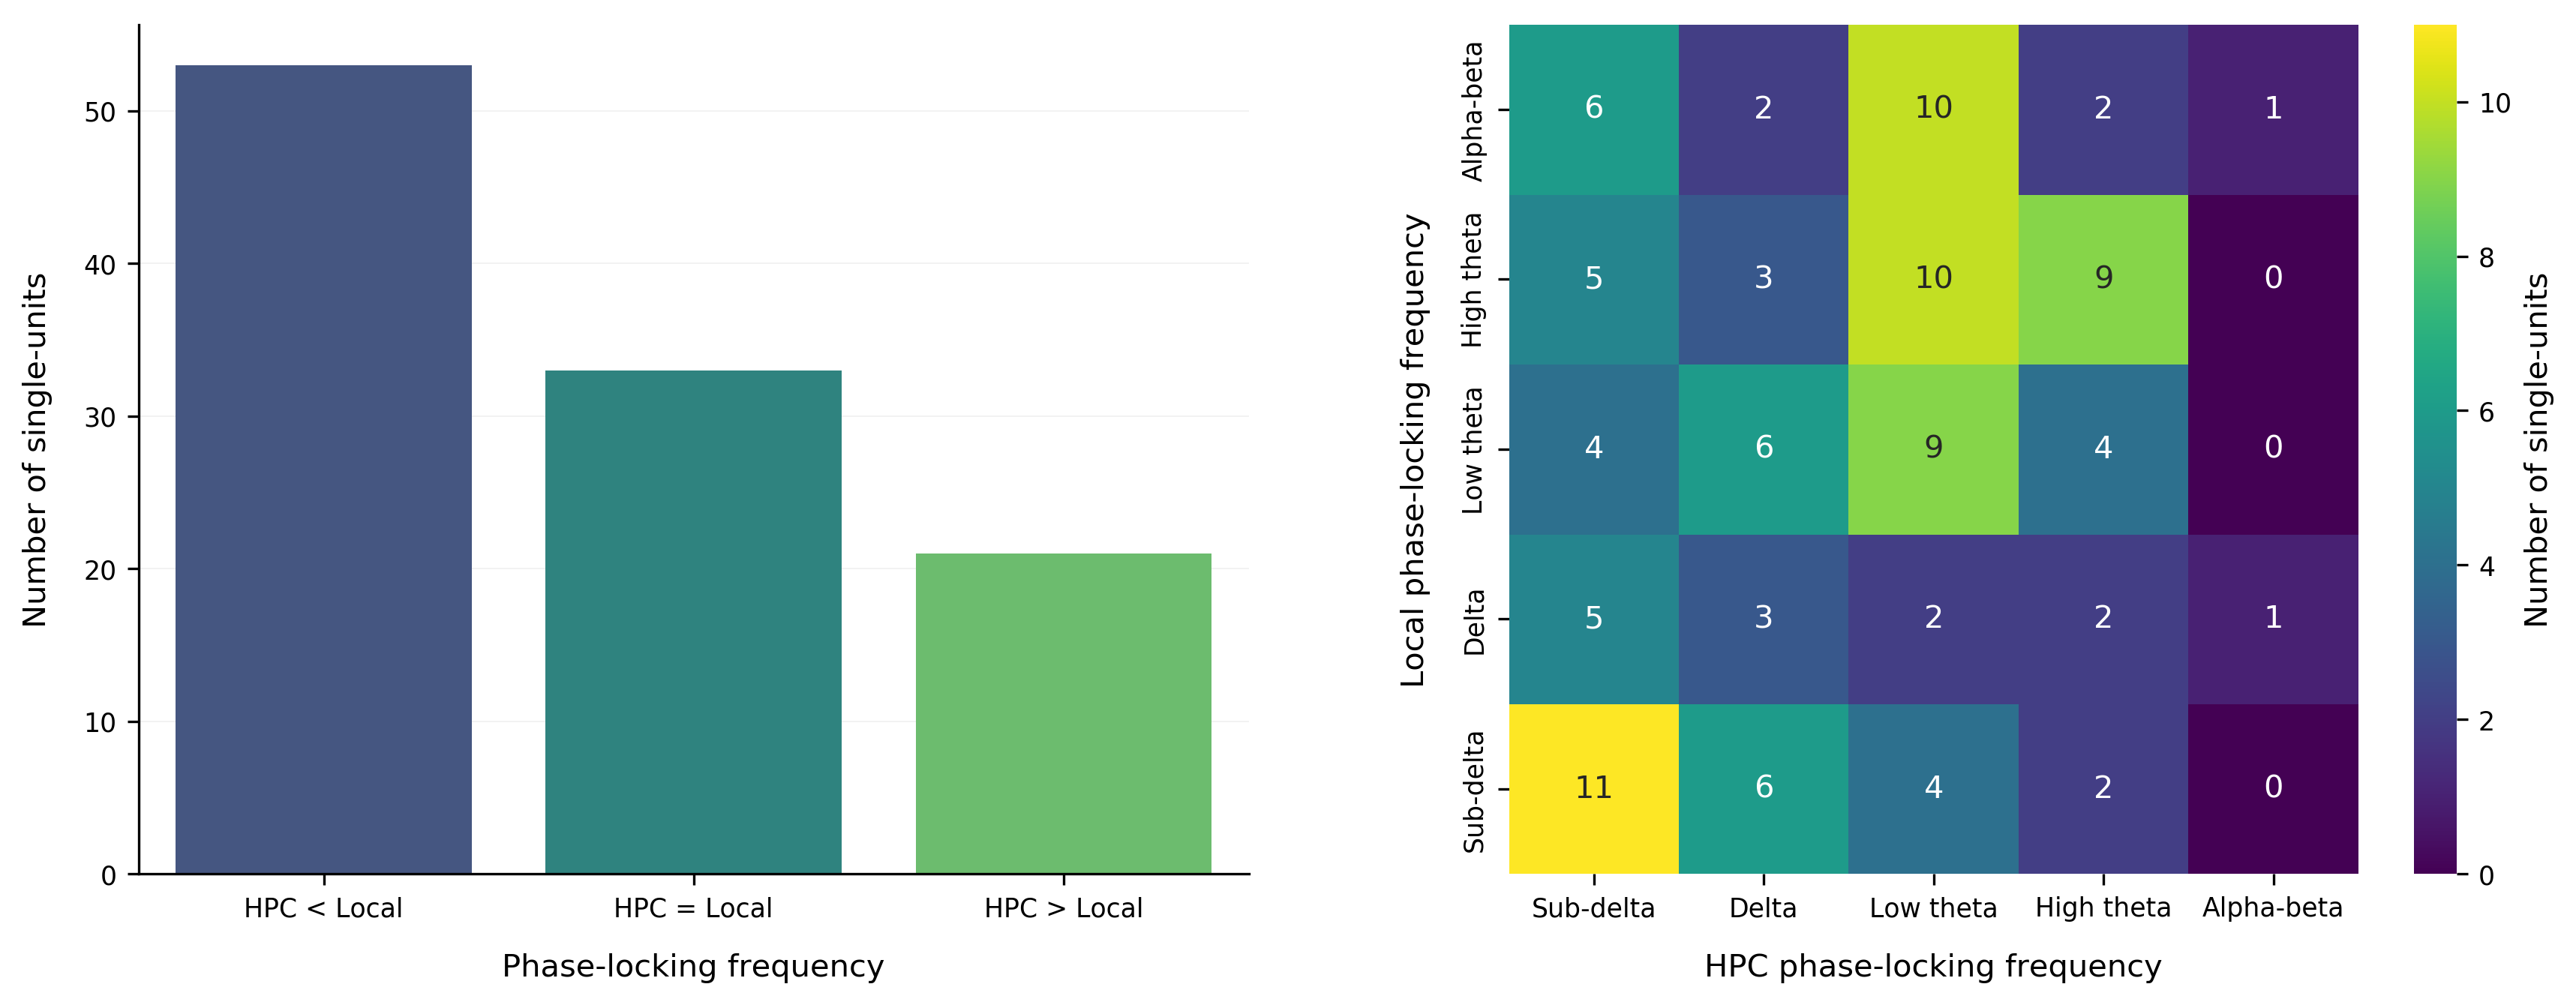

In [792]:
m = df.groupby(['local', 'hpc']).size().unstack()
m = m.fillna(0)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='cat', y='count', data=counts, palette='viridis', ax=ax[0])
ax[0].set_xticklabels(['HPC < Local', 'HPC = Local', 'HPC > Local'])
ax[0].set_xlabel('Phase-locking frequency', fontsize=10, labelpad=10)
ax[0].set_ylabel('Number of single-units', fontsize=10, labelpad=10)

sns.heatmap(m, annot=True, ax=ax[1], cmap='viridis', square=True)
ax[1].set_xticklabels(bands_fancy2.values(), ha='center')
ax[1].set_yticklabels(bands_fancy2.values(), va='center')
ax[1].set_xlabel('HPC phase-locking frequency', fontsize=10, labelpad=10)
ax[1].set_ylabel('Local phase-locking frequency', fontsize=10, labelpad=10)
ax[1].invert_yaxis()
cbar = ax[1].collections[0].colorbar
cbar.set_label('Number of single-units', fontsize=10)

## Time lag analysis

In [916]:
tl_df = phase_locking.calc_cross_electrode_phase_locking_timelag('U390_ses3',
                                                                 bands=bands,
                                                                 interp_spikes=interp_spikes,
                                                                 notch_freqs=notch_freqs,
                                                                 phase_type=phase_type,
                                                                 mask_type=mask_type,
                                                                 hpc_subset=True)

In [949]:
# Load all cross-electrode files into a single dataframe.
tl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/time_lag', 
                             '*_crosselec_phaselock_df_notch60-120_nospikeinterp_phase-extrema2_nomask_hpc-subset_timelag-2to2sec-step10ms_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(tl_files)))

tl_df = dio.open_pickle(tl_files[0])
for f in tl_files[1:]:
    tl_df = tl_df.append(dio.open_pickle(f))
tl_df.reset_index(drop=True, inplace=True)

Found 14 files


In [955]:
pl_df = pd.merge(pl_df, tl_df[['subj_sess_unit', 'lfp_chan_ind', 'pvals']].rename(columns={'pvals': 'ts_pvals'}),
                 how='inner', on=['subj_sess_unit', 'lfp_chan_ind'])

In [985]:
pl_df['ts_locked_pvals'] = pl_df.ts_pvals.apply(lambda x: x[np.argmin(x, axis=0), np.arange(x.shape[1], dtype=int)])

In [1034]:
(np.arange(10) < np.expand_dims(np.arange(5), axis=1)).T, np.expand_dims(np.arange(10), axis=1) < np.arange(5)

(array([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]]),
 array([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]]))

In [1043]:
np.sum(np.expand_dims(pl_df['bs_pval_vec'][0], axis=1) < pl_df['ts_locked_pvals'][0], axis=0)[200], pl_df.bs_pval_ind[0]

(81, 85)

In [1056]:
ts_bs_pvals = []
for index, row in pl_df.iterrows():
    ts_bs_pvals_ = []
    for i in range(len(row['ts_locked_pvals'])):
        ts_bs_pvals_.append(np.sum(row['bs_pval_vec'] <= row['ts_locked_pvals'][i]))
    ts_bs_pvals.append(np.array(ts_bs_pvals_))
pl_df['ts_bs_pvals'] = ts_bs_pvals
pl_df['ts_bs_pvals'] = (1 + pl_df['ts_bs_pvals']) / 10001

In [1081]:
ts_sig = []
for index, row in pl_df.iterrows():
    ts_sig.append(row['ts_bs_pvals'] < row['bonf_alpha'])
pl_df['ts_sig'] = ts_sig

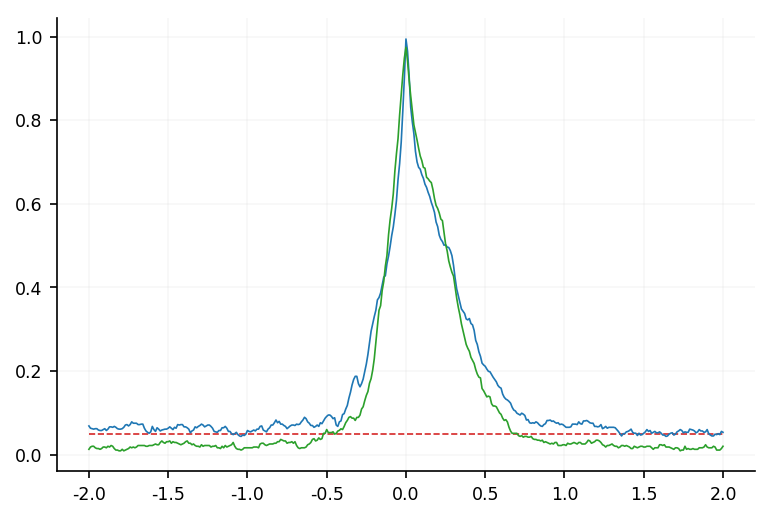

In [1095]:
plt.plot(np.mean(np.array(pl_df.query("(sig==True) & (subj_sess_unit=={}) & (lfp_is_hpc==False)".format(ehip_units)).ts_sig.tolist()), axis=0))
plt.plot(np.mean(np.array(pl_df.query("(sig==True) & (subj_sess_unit=={}) & (lfp_is_hpc==True)".format(ehip_units)).ts_sig.tolist()), axis=0), color='C2')
#plt.plot(np.mean(np.array(pl_df.ts_sig.tolist()), axis=0), color='C9')
plt.hlines(0.05, 0, 400, linestyle='--', color='C1')
plt.xticks(np.arange(0, 450, 50), np.arange(-2, 2.5, .5))
plt.show()

In [1044]:
# ts_bs_pvals = []
# for index, row in pl_df.iterrows():
#     ts_bs_pvals.append(np.sum(np.expand_dims(row['bs_pval_vec'], axis=1) <= row['ts_locked_pvals'], axis=1))
# pl_df['ts_bs_pvals'] = ts_bs_pvals

In [1071]:
np.array(pl_df.query("(sig==True)").ts_bs_pvals.tolist())[:, 200], np.array(pl_df.query("(sig==True)").bs_pval.tolist())

(array([9.9990001e-05, 9.9990001e-05, 9.9990001e-05, ..., 9.9990001e-05,
        9.9990001e-04, 9.9990001e-05]),
 array([9.99900010e-05, 9.99900010e-05, 9.99900010e-05, ...,
        9.99900010e-05, 4.99950005e-04, 9.99900010e-05]))

In [1069]:
stats.spearmanr(np.array(pl_df.query("(sig==True)").ts_bs_pvals.tolist())[:, 200], np.array(pl_df.query("(sig==True)").bs_pval.tolist()))

SpearmanrResult(correlation=0.9630652907507701, pvalue=0.0)

In [1054]:
stats.pearsonr(np.array(pl_df.query("(sig==True)").ts_bs_pvals.tolist())[:, 200], np.array(pl_df.query("(sig==True)").bs_pval_ind.tolist()))

(0.003500492086949311, 0.8803370375802162)

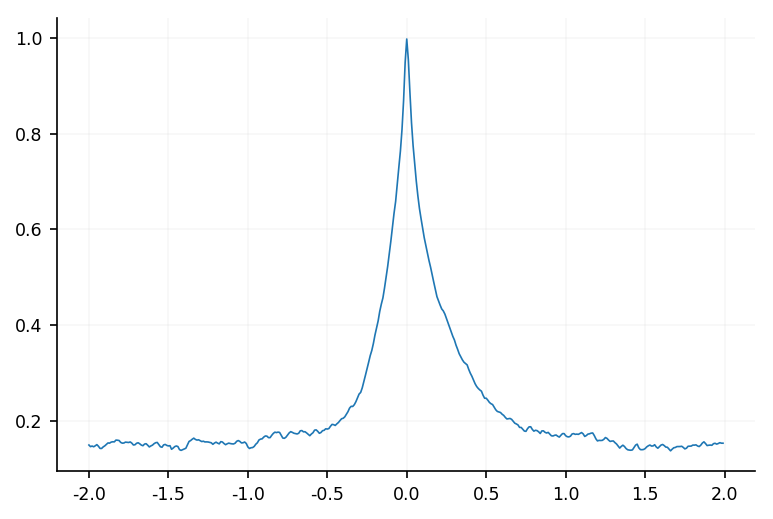

In [953]:
corrs = []
for i in range(400):
    corrs.append(stats.spearmanr(np.array(df.ts_pvals.apply(lambda x: x[:, i]).tolist()).flatten(), np.array(df.pvals.tolist()).flatten())[0])
plt.plot(np.array(corrs))
plt.xticks(np.arange(0, 450, 50), np.arange(-2, 2.5, .5))
plt.show()

## Something else

In [382]:
# Convert bootstrap p-values to 
pvals = np.array(pl_df.loc[pl_df.bs_pval_vec.apply(lambda x: len(x)>0), 'bs_pval_vec'].tolist())
pvals[pvals==0] = min(pvals[pvals>0])
nspikes = np.expand_dims(np.array(pl_df.loc[pl_df.bs_pval_vec.apply(lambda x: len(x)>0), 'unit_nspikes'].tolist()), axis=1)
pl_df.bs_lengths_vec = []
pl_df.loc[pl_df.bs_pval_vec.apply(lambda x: len(x)>0), 'bs_lengths_vec'] = list(np.sqrt(-np.log(pvals) * nspikes) / nspikes)

ValueError: Must have equal len keys and value when setting with an ndarray

In [386]:
pl_df.loc[pl_df.bs_pval_vec.apply(lambda x: len(x)>0)]['bs_lengths_vec'] = list(mrls)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [388]:
pl_df.bs_lengths_vec = []

In [389]:
pl_df.bs_lengths_vec

[]

In [377]:
pl_df.bs_lengths_vec = []
pl_df.loc[pl_df.bs_pval_vec.apply(lambda x: len(x)>0), 'bs_lengths_vec'] = list(np.sqrt(-np.log(pvals) * nspikes) / nspikes)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


ValueError: Must have equal len keys and value when setting with an ndarray

In [364]:
np.sqrt(-np.log(pvals) * nspikes) / nspikes

AttributeError: 'numpy.ndarray' object has no attribute 'log'

In [ ]:
# Time lag.


## Older

In [198]:
# How many units are we looking at for each region-region
# comparison (taking all unit->region pairs)?
df = (pl_df.groupby(['subj_sess', 'unit_roi2', 'unit', 'lfp_roi2'])
           .agg({'n_comparisons': len,
                 'sig': np.sum})
           .reset_index())

nunits_df = df.groupby(['unit_roi2', 'lfp_roi2']).size()
nunits_df.unstack()

lfp_roi2,amy,ctx,ec,hpc,phg
unit_roi2,,,,,
amy,149,86,95,138,81
ctx,118,191,111,191,72
ec,57,60,82,80,60
hpc,98,93,80,138,77
phg,74,42,58,81,81


Text(0.5,0.95,'Sample size')

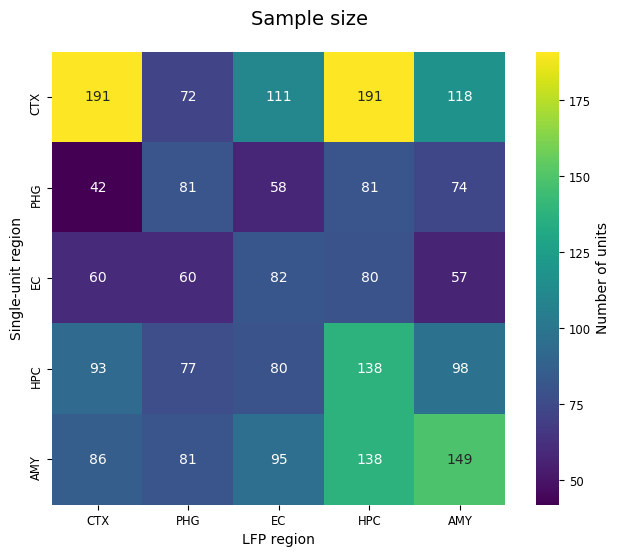

In [347]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
sns.heatmap(nunits_df.unstack().iloc[[1, 4, 2, 3, 0], [1, 4, 2, 3, 0]],
            annot=True, fmt='d', ax=ax, cmap='viridis', square=True)
ax.set_xticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_yticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_xlabel('LFP region', fontsize=10)
ax.set_ylabel('Single-unit region', fontsize=10)
cbar = ax.collections[0].colorbar
cbar.set_label('Number of units', fontsize=10)
fig.suptitle('Sample size', fontsize=14, y=0.95)

In [131]:
# What percent of units are phase-locked at any frequency
# for each region->region comparison (taking all unit->region pairs)?
df = (pl_df.groupby(['subj_sess', 'unit_roi2', 'unit', 'lfp_roi2'])
           .agg({'n_comparisons': len,
                 'sig': np.sum})
           .reset_index())
df['sig_bool'] = df.sig > 0
r2r_df = df.groupby(['unit_roi2', 'lfp_roi2']).sig_bool.mean()
r2r_df

unit_roi2  lfp_roi2
amy        amy         0.610738
           ctx         0.255814
           ec          0.568421
           hpc         0.615942
           phg         0.345679
ctx        amy         0.203390
           ctx         0.565445
           ec          0.270270
           hpc         0.235602
           phg         0.319444
ec         amy         0.280702
           ctx         0.166667
           ec          0.560976
           hpc         0.512500
           phg         0.166667
hpc        amy         0.438776
           ctx         0.322581
           ec          0.575000
           hpc         0.695652
           phg         0.350649
phg        amy         0.162162
           ctx         0.285714
           ec          0.120690
           hpc         0.358025
           phg         0.518519
Name: sig_bool, dtype: float64

Text(0.5,0.95,'Inter-regional phase-locking')

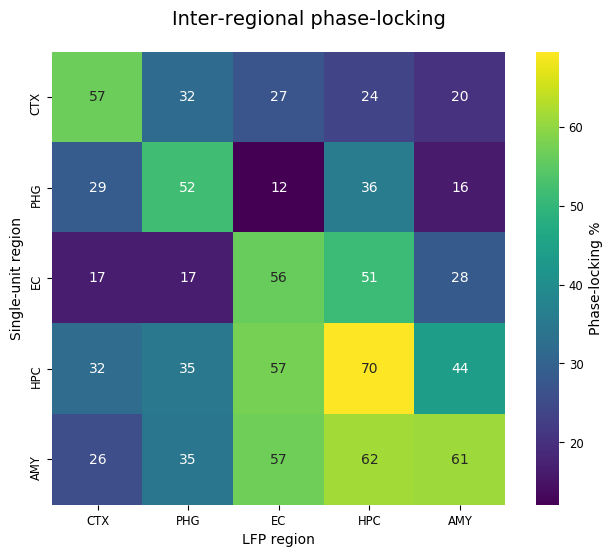

In [345]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
sns.heatmap(r2r_df.unstack().iloc[[1, 4, 2, 3, 0], [1, 4, 2, 3, 0]] * 100,
            annot=True, ax=ax, cmap='viridis', square=True)
ax.set_xticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_yticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_xlabel('LFP region', fontsize=10)
ax.set_ylabel('Single-unit region', fontsize=10)
cbar = ax.collections[0].colorbar
cbar.set_label('Phase-locking %', fontsize=10)
fig.suptitle('Inter-regional phase-locking', fontsize=14, y=0.95)

In [313]:
# What frequencies are they phase-locked at?
# What percent of units are phase-locked at any frequency
# for each region->region comparison (taking all unit->region pairs)?
nunits = nunits_df.to_dict()
nunits_sig = OrderedDict()
for band_name in band_names:
    df = (pl_df.query("(sig==True) & (locked_band=='{}')".format(band_name))
          .groupby(['subj_sess', 'unit_roi2', 'unit', 'lfp_roi2'])
          .agg({'n_comparisons': len,
                'sig': np.sum})
          .reset_index())
    nunits_sig[band_name] = df.groupby(['unit_roi2', 'lfp_roi2']).size().to_dict()
    
rois = ['ctx', 'phg', 'ec', 'hpc', 'amy']
pct_sig = []
for band_name in band_names:
    for unit_roi in rois:
        for lfp_roi in rois:
            pct_sig.append([band_name, unit_roi, lfp_roi, nunits_sig[band_name].get((unit_roi, lfp_roi), 0) / nunits[(unit_roi, lfp_roi)]])

pct_by_band = pd.DataFrame(np.array(pct_sig), columns=['band', 'unit_roi', 'lfp_roi', 'pct'])
pct_by_band.pct = pct_by_band.pct.astype(np.float32)

Text(0.5,0.95,'Alpha-beta (8-32 Hz) phase-locking')

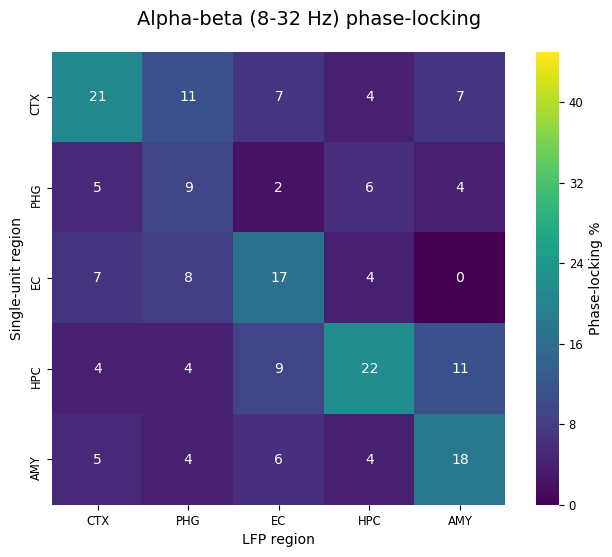

In [346]:
band_name = 'alpha_beta'

dat = pct_by_band.query("(band=='{}')".format(band_name)).iloc[:, 1:].set_index(['unit_roi', 'lfp_roi'])
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
sns.heatmap(np.round(dat.unstack().iloc[[1, 4, 2, 3, 0], [1, 4, 2, 3, 0]] * 100),
            annot=True, ax=ax, cmap='viridis', vmin=0, vmax=45, square=True)
ax.set_xticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_yticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_xlabel('LFP region', fontsize=10)
ax.set_ylabel('Single-unit region', fontsize=10)
cbar = ax.collections[0].colorbar
cbar.set_label('Phase-locking %', fontsize=10)
fig.suptitle('{} phase-locking'.format(bands_fancy[band_name]), fontsize=14, y=0.95)

- Hippocampus:  109 138
- Parahippocampal:  143 163
- Amygdala:  116 149
- Frontal:  53 69
- Cortex (Other):  104 122

In [384]:
# What are the mean resultant lengths of significantly phase-locked pairs?
df = (pl_df.query("(sig==True)")
           .groupby(['subj_sess', 'unit_roi2', 'unit', 'lfp_roi2'])
           .agg({'locked_length': max,  
                 'n_comparisons': len,
                 'sig': np.sum})
           .reset_index())
r2r_mrl_df = df.groupby(['unit_roi2', 'lfp_roi2']).locked_length.mean()

Text(0.5,0.95,'Inter-regional phase-locking strength')

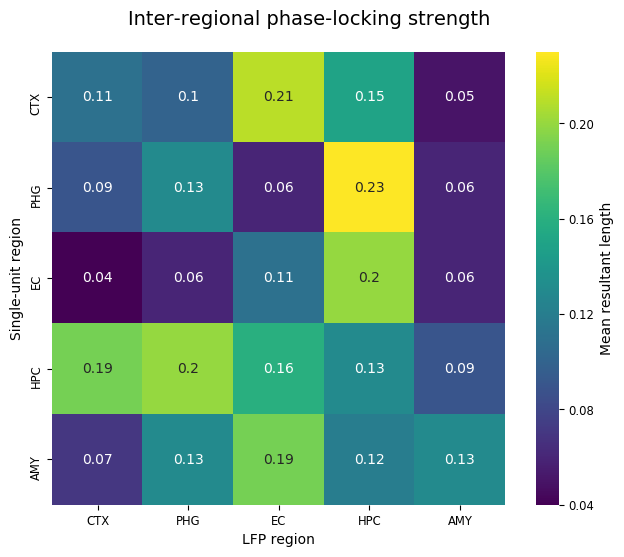

In [387]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
sns.heatmap(np.round(r2r_mrl_df.unstack(), 2).iloc[[1, 4, 2, 3, 0], [1, 4, 2, 3, 0]],
            annot=True, ax=ax, cmap='viridis', square=True)
ax.set_xticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_yticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_xlabel('LFP region', fontsize=10)
ax.set_ylabel('Single-unit region', fontsize=10)
cbar = ax.collections[0].colorbar
cbar.set_label('Mean resultant length', fontsize=10)
fig.suptitle('Inter-regional phase-locking strength', fontsize=14, y=0.95)

In [16]:
# What is the mean resultant length by phase-lock band
# for each region->region comparison (taking all unit->region pairs)?
mrls_by_band = OrderedDict()
for band_name in band_names:
    df = (pl_df.query("(sig==True) & (locked_band=='{}')".format(band_name))
          .groupby(['subj_sess', 'unit_roi2', 'unit', 'lfp_roi2'])
          .agg({'n_comparisons': len,
                'locked_length': max,
                'sig': np.sum})
          .reset_index())
    mrls_by_band[band_name] = np.round(df.groupby(['unit_roi2', 'lfp_roi2']).locked_length.mean(), 2)

Text(0.5,0.95,'Sub-delta (0.5-2 Hz) phase-locking strength')

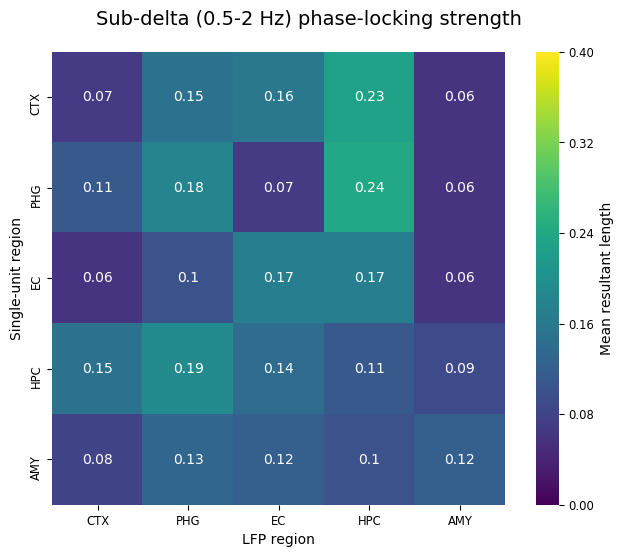

In [26]:
band_name = 'sub_delta'

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
sns.heatmap(mrls_by_band[band_name].unstack().iloc[[1, 4, 2, 3, 0], [1, 4, 2, 3, 0]],
            annot=True, ax=ax, cmap='viridis', vmin=0, vmax=0.4, square=True)
ax.set_xticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_yticklabels(['CTX', 'PHG', 'EC', 'HPC', 'AMY'])
ax.set_xlabel('LFP region', fontsize=10)
ax.set_ylabel('Single-unit region', fontsize=10)
cbar = ax.collections[0].colorbar
cbar.set_label('Mean resultant length', fontsize=10)
fig.suptitle('{} phase-locking strength'.format(bands_fancy[band_name]), fontsize=14, y=0.95)

## What is going on with gamma phase-locking?
Test the hypothesis that brain-wide noise may be contributing to false spikes and LFP inflections

In [1015]:
spikes, fr_df, clus_to_chan, chan_to_clus = phase_locking.load_spikes(sessions[0])

In [1016]:
spike_trains = np.array(fr_df.spikes.tolist())

In [1027]:
arr10 = aop.rolling_func(spike_trains, np.sum, window=21, right_fill=0) # 30ms time window
arr10 = np.roll(arr10, shift=10, axis=1) # center each window on its original time
arr10[arr10>0] = 1 # 1 if a spike is observed in the window

arr30 = aop.rolling_func(spike_trains, np.sum, window=61, right_fill=0) # 30ms time window
arr30 = np.roll(arr30, shift=30, axis=1) # center each window on its original time
arr30[arr30>0] = 1 # 1 if a spike is observed in the window

arr100 = aop.rolling_func(spike_trains, np.sum, window=201, right_fill=0) # 30ms time window
arr100 = np.roll(arr100, shift=100, axis=1) # center each window on its original time
arr100[arr100>0] = 1 # 1 if a spike is observed in the window

In [1028]:
xvals10, yvals10 = np.unique(np.sum(arr10, axis=0), return_counts=True)
xvals30, yvals30 = np.unique(np.sum(arr30, axis=0), return_counts=True)
xvals100, yvals100 = np.unique(np.sum(arr100, axis=0), return_counts=True)

In [1022]:
arr = aop.rolling_func(spike_trains, np.sum, window=61, right_fill=0) # 30ms time window
arr = np.roll(arr, shift=30, axis=1) # center each window on its original time
arr[arr>0] = 1 # 1 if a spike is observed in the window

In [1023]:
xvals, yvals = np.unique(np.sum(arr, axis=0), return_counts=True)

In [1024]:
np.percentile(np.sum(arr, axis=0), 75)

8.0

In [1025]:
# The mask identifies all timepoints where the number of units with 1+ co-occuring spikes within a 30ms window
mask = np.tile(np.sum(arr, axis=0)<np.percentile(np.sum(arr, axis=0), 75), reps=arr.shape[0]).reshape(arr.shape)

Text(0.5,1,'Co-occuring spikes across units')

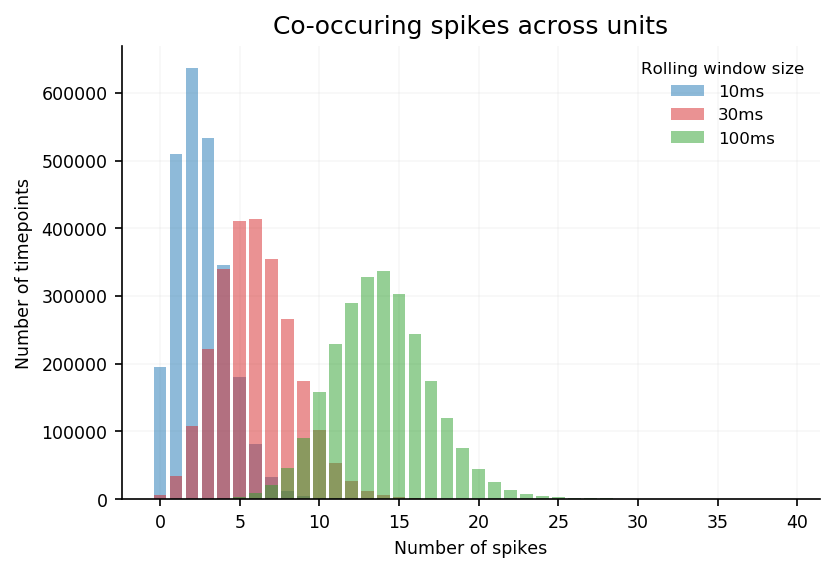

In [1048]:
plt.figure(dpi=150)
plt.bar(xvals10, yvals10, alpha=0.5, label='10ms')
plt.bar(xvals30, yvals30, alpha=0.5, label='30ms')
plt.bar(xvals100, yvals100, alpha=0.5, label='100ms')
plt.xlabel('Number of spikes')
plt.ylabel('Number of timepoints')
legend = plt.legend(title='Rolling window size', fontsize=8)
plt.setp(legend.get_title(),fontsize=8)
plt.title('Co-occuring spikes across units', fontsize=12)